## Обработка графиков ЭКГ и преобразование в таблицу

In [1]:
import pywt
import scipy
import os
from pylab import *
from numpy import*
import pandas as pd

import matplotlib.pyplot as plt
from peakdetect import peakdetect
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split

In [2]:
def get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = np.load(way).transpose().reshape((60000,))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [3]:
def into_one_table(keys, directory): # преобразование графиков в таблицу
    row = get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [668]:
%%time
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-3])))
ECG_data = into_one_table(target, 'train/') # таблица с графиками

CPU times: total: 8.78 s
Wall time: 14.4 s


In [669]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'record_name'})

In [670]:
ECG_data = ECG_data.sort_values(by=['record_name'], ascending=True)

In [671]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.558936,0.551860,0.551007,0.561618,0.556675,0.645774,0.744957,0.649421,0.667106,0.731759
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.113606,1.088111,1.099680,1.132341,1.130250,1.788834,2.455783,1.818630,1.938019,2.363243
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.341701,0.340029,0.342162,0.341734,0.340499,0.346990,0.366654,0.343959,0.348800,0.365320
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.267047,-0.258175,-0.261318,-0.274144,-0.273755,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.304742,-0.297821,-0.302716,-0.310384,-0.311176,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.005842,0.004748,0.005003,0.006885,0.006829,0.041791,0.079657,0.044349,0.050701,0.074361
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.120157,0.117738,0.121368,0.121892,0.122540,0.189928,0.260724,0.190226,0.204078,0.251573
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.128999,-0.124998,-0.127924,-0.131497,-0.131004,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.159457,-0.155589,-0.158779,-0.161389,-0.160510,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710


## Объединение таблиц, разбиение на тренировочную и валидационную выборки

In [672]:
df = pd.read_csv('train/train_meta.csv')
df.record_name = list(map(lambda x: int(x.strip('_hr')), df.record_name))
df

,patient_id,age,sex,height,weight,record_name
0,18792.0,55.0,0,NaN,70.0,9
1,13619.0,56.0,0,NaN,NaN,34
2,11315.0,25.0,1,NaN,63.0,43
3,18153.0,35.0,0,NaN,82.0,52
4,16063.0,26.0,0,NaN,93.0,57
...,...,...,...,...,...,...
2096,12488.0,66.0,1,NaN,NaN,21784
2097,10162.0,68.0,0,NaN,NaN,21795
2098,11197.0,59.0,0,NaN,NaN,21825
2099,11905.0,55.0,1,NaN,NaN,21831


In [673]:
ECG_data = ECG_data.merge(df, on='record_name', how='left')

In [674]:
gts = pd.read_csv('train/train_gts_final.csv')
gts.record_name = list(map(lambda x: int(x.strip('_hr')), gts.record_name))
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма,record_name
0,0,0,0,0,0,0,1,669
1,0,0,0,0,0,0,1,209
2,0,0,0,0,0,0,1,777
3,0,0,0,0,0,0,1,1394
4,0,0,0,0,0,0,1,1618
...,...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1,20864
2097,0,0,0,0,0,0,1,20967
2098,0,0,0,0,0,0,1,21744
2099,0,0,0,0,0,0,1,3465


In [675]:
ECG_data = ECG_data.merge(gts, on='record_name', how='left')

In [676]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,sex,height,weight,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0,NaN,70.0,0,0,0,0,0,0,1
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,0,NaN,NaN,0,0,0,0,0,0,1
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,1,NaN,63.0,0,0,0,0,0,0,1
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,0,NaN,82.0,0,0,0,0,0,0,1
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,0,NaN,93.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,1,NaN,NaN,0,0,0,0,0,0,1
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0,NaN,NaN,0,0,0,0,0,0,1
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,0,NaN,NaN,0,0,0,0,0,0,1
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,1,NaN,NaN,0,0,0,0,0,0,1


In [677]:
gts = ECG_data[['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный', 'нижний', 'норма']]
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1
2097,0,0,0,0,0,0,1
2098,0,0,0,0,0,0,1
2099,0,0,0,0,0,0,1


In [678]:
ECG_data = ECG_data.drop(['перегородочный', 'передний', 'боковой', 'передне-боковой',
                          'передне-перегородочный', 'нижний', 'норма'], axis=1)

In [679]:
ECG_data_train, ECG_data_val, myocard_train, myocard_val = train_test_split(ECG_data, gts, random_state=0)

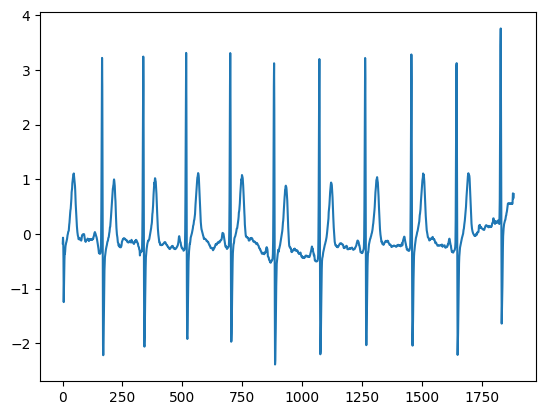

In [680]:
plt.plot(ECG_data.iloc[0, 1:-5]) # график экг после обработки сигнала

In [681]:
df_train = ECG_data_train.iloc[:, -5:]
df_val = ECG_data_val.iloc[:, -5:]

In [682]:
df_train

,patient_id,age,sex,height,weight
1592,4964.0,22.0,1,163.0,90.0
918,16196.0,84.0,0,NaN,NaN
122,767.0,61.0,0,183.0,83.0
684,12056.0,74.0,1,NaN,NaN
214,2452.0,60.0,1,152.0,NaN
...,...,...,...,...,...
1033,18617.0,49.0,0,NaN,NaN
1731,4102.0,64.0,1,168.0,66.0
763,10524.0,34.0,0,NaN,72.0
835,10717.0,55.0,0,NaN,NaN


In [683]:
ECG_data_train = ECG_data_train.iloc[:, :-5]
ECG_data_val = ECG_data_val.iloc[:, :-5]

In [684]:
ECG_data_train

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1592,16603,0.109449,0.185223,0.125672,-0.151371,-0.829218,-0.622236,-0.656209,-0.655158,-0.620203,...,-0.276397,-0.271167,-0.271356,-0.278988,-0.276562,-0.365569,-0.453599,-0.369220,-0.385059,-0.441318
918,9557,-1.490900,-1.394463,-1.459593,-1.758585,-2.413724,-2.193418,-1.980952,-1.772527,-1.498688,...,1.808763,1.794004,1.791578,1.824338,1.824525,2.338546,2.856921,2.381495,2.466389,2.781295
122,1511,0.410295,0.418111,0.411441,0.385160,0.316728,0.322976,0.268045,0.196556,0.132210,...,0.429139,0.419976,0.423895,0.435734,0.434976,0.667413,0.897665,0.677479,0.718923,0.865508
684,7125,-0.121402,-0.121375,-0.120977,-0.119733,-0.114203,-0.115726,-0.117201,-0.126269,-0.128501,...,0.680528,0.667779,0.672897,0.689272,0.687265,0.994409,1.308699,1.007843,1.064270,1.265372
214,2316,0.028528,-0.025202,0.009788,0.172212,0.546162,0.536875,1.251363,2.411523,3.051960,...,-0.384466,-0.378909,-0.380860,-0.388554,-0.387973,-0.530641,-0.673326,-0.537565,-0.562936,-0.653343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,10677,1.348874,1.394465,1.405025,1.479370,1.920034,1.547778,0.474275,-0.755991,-1.562751,...,-0.187951,-0.184040,-0.186707,-0.190465,-0.189940,-0.280883,-0.378106,-0.283582,-0.301543,-0.365178
1731,18020,-0.285911,-0.265134,-0.282379,-0.365458,-0.574443,-0.503349,-0.498727,-0.482626,-0.459739,...,-0.247702,-0.239041,-0.247471,-0.255108,-0.257066,-0.526102,-0.801259,-0.535676,-0.586126,-0.763746
763,7978,-0.316812,-0.305549,-0.314139,-0.357382,-0.462342,-0.426322,-0.437142,-0.429418,-0.412790,...,-0.151037,-0.149981,-0.150161,-0.152364,-0.152745,-0.197529,-0.242362,-0.200993,-0.208471,-0.235857
835,8797,-0.897106,-0.901242,-0.897541,-0.887869,-0.862189,-0.857458,-0.841005,-0.826645,-0.800221,...,0.142141,0.140497,0.141669,0.143489,0.143677,0.191975,0.240699,0.193946,0.202788,0.233976


## N-граммы

In [685]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from catboost import CatBoostClassifier

In [686]:
def find_peaks(ecgsignal, peak): # нахождение пиков
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [740]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
    ecgsignal_split = []
    cycle = []
    rpeaks = rpeaks[::-1]
    f = True #флаг конца массива с пиками
    f1 = True #флаг вхождения первого пика
    for i in range(len(ecgsignal)):
        if f and i == rpeaks[-1]:
            if f1:
                f1 = False
                cycle = []
            else:
                ecgsignal_split.append(cycle)
                cycle = []
            rpeaks = rpeaks[:-1]
            if f and len(rpeaks) == 0:
                f = False
        cycle.append(ecgsignal[i])
    return ecgsignal_split

In [688]:
def sign(x): # возвращает знак числа
   return 1 if x > 0 else -1

In [689]:
def RTL(ecgsignal_split): # получение списка приращения амплитуд R, интервалов T, углов L
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [690]:
def letters(data): # кодирование цикла по В.М. Успенскому
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [691]:
def encoding(ecgsignal_split): # кодирование циклов в строку по В.М. Успенскому
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [692]:
def counter_and_sort(arr): # считает и сортирует н-граммы
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [693]:
def func(ng):  # возвращает список количества н-грамм, относящихся к каждой категории
    # н-граммы, встречающиеся только в этой категории
    ng_healthy = sum(list(map(lambda x: 1 if x in only_healthy else 0, ng))) 
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))
    
    ng_septal_0 = sum(list(map(lambda x: 1 if x in only_septal_0 else 0, ng)))
    ng_septal_1 = sum(list(map(lambda x: 1 if x in only_septal_1 else 0, ng)))
    
    ng_front_0 = sum(list(map(lambda x: 1 if x in only_front_0 else 0, ng)))
    ng_front_1 = sum(list(map(lambda x: 1 if x in only_front_1 else 0, ng)))
    
    ng_side_0 = sum(list(map(lambda x: 1 if x in only_side_0 else 0, ng)))
    ng_side_1 = sum(list(map(lambda x: 1 if x in only_side_1 else 0, ng)))
    
    ng_front_side_0 = sum(list(map(lambda x: 1 if x in only_front_side_0 else 0, ng)))
    ng_front_side_1 = sum(list(map(lambda x: 1 if x in only_front_side_1 else 0, ng)))
    
    ng_front_septal_0 = sum(list(map(lambda x: 1 if x in only_front_septal_0 else 0, ng)))
    ng_front_septal_1 = sum(list(map(lambda x: 1 if x in only_front_septal_1 else 0, ng)))
    
    ng_lower_0 = sum(list(map(lambda x: 1 if x in only_lower_0 else 0, ng)))
    ng_lower_1 = sum(list(map(lambda x: 1 if x in only_lower_1 else 0, ng)))
    
    # н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
    ng_popular_healthy = sum(list(map(lambda x: 1 if x in popular_healthy_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))
    
    ng_popular_septal_0 = sum(list(map(lambda x: 1 if x in popular_septal_0_only else 0, ng)))
    ng_popular_septal_1 = sum(list(map(lambda x: 1 if x in popular_septal_1_only else 0, ng)))
    
    ng_popular_front_0 = sum(list(map(lambda x: 1 if x in popular_front_0_only else 0, ng)))
    ng_popular_front_1 = sum(list(map(lambda x: 1 if x in popular_front_1_only else 0, ng)))
    
    ng_popular_side_0 = sum(list(map(lambda x: 1 if x in popular_side_0_only else 0, ng)))
    ng_popular_side_1 = sum(list(map(lambda x: 1 if x in popular_side_1_only else 0, ng)))
    
    ng_popular_front_side_0 = sum(list(map(lambda x: 1 if x in popular_front_side_0_only else 0, ng)))
    ng_popular_front_side_1 = sum(list(map(lambda x: 1 if x in popular_front_side_1_only else 0, ng)))
    
    ng_popular_front_septal_0 = sum(list(map(lambda x: 1 if x in popular_front_septal_0_only else 0, ng)))
    ng_popular_front_septal_1 = sum(list(map(lambda x: 1 if x in popular_front_septal_1_only else 0, ng)))
    
    ng_popular_lower_0 = sum(list(map(lambda x: 1 if x in popular_lower_0_only else 0, ng)))
    ng_popular_lower_1 = sum(list(map(lambda x: 1 if x in popular_lower_1_only else 0, ng)))
    
    return array([[ng_healthy, ng_popular_healthy, ng_sick, ng_popular_sick],
                  [ng_septal_0, ng_popular_septal_0, ng_septal_1, ng_popular_septal_1],
                  [ng_front_0, ng_popular_front_0, ng_front_1, ng_popular_front_1],
                  [ng_side_0, ng_popular_side_0, ng_side_1, ng_popular_side_1],
                  [ng_front_side_0, ng_popular_front_side_0, ng_front_side_1, ng_popular_front_side_1],
                  [ng_front_septal_0, ng_popular_front_septal_0, ng_front_septal_1, ng_popular_front_septal_1],
                  [ng_lower_0, ng_popular_lower_0, ng_lower_1, ng_popular_lower_1]])

In [694]:
def sp_n_gramms(ngramma):  # получение н-грамм
    sp = []
    for i in ngramma:
        n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 5))))
        for k in n:
            sp.append(k)
    return sp

In [695]:
ECG_data_array_train = np.array(ECG_data_train)

In [696]:
R_Peaks_train = []

In [697]:
ecg_ids_train = []
encoding_ecgs_train = []

In [698]:
for ecgsignal in ECG_data_array_train: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_train.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_train.append(ecg_id)
    encoding_ecgs_train.append(encoding_ecg)

In [699]:
encoding_ecg_train = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_train.encoding_ecg = encoding_ecgs_train
encoding_ecg_train.ecg_id = ecg_ids_train
encoding_ecg_train = encoding_ecg_train.sort_values(by='ecg_id')
encoding_ecg_train[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_train)
encoding_ecg_train

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1027,DDCADDCC,9.0,0,0,0,0,0,0,1
189,BFABCFADDEC,43.0,0,0,0,0,0,0,1
1064,DDEFBCCBCCF,52.0,0,0,0,0,0,0,1
43,DDCADBCDD,57.0,0,0,0,0,0,0,1
1110,FFCCFDCFDA,96.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
365,EBDCEBDCEB,21756.0,0,0,0,0,0,0,1
181,BCEFCCDDFAF,21774.0,0,0,0,0,0,0,1
344,AEDDDCCD,21775.0,0,0,0,0,0,0,1
1389,ECCDDDECB,21825.0,0,1,0,0,0,0,0


In [700]:
encoding_ecg_train.норма.sum()

1269

In [701]:
healthy = encoding_ecg_train[encoding_ecg_train['норма'] == 1].encoding_ecg  # закодированные кардиограммы по категориям
sick = encoding_ecg_train[encoding_ecg_train['норма'] == 0].encoding_ecg

septal_0 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 0].encoding_ecg
septal_1 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 1].encoding_ecg

front_0 = encoding_ecg_train[encoding_ecg_train['передний'] == 0].encoding_ecg
front_1 = encoding_ecg_train[encoding_ecg_train['передний'] == 1].encoding_ecg

side_0 = encoding_ecg_train[encoding_ecg_train['боковой'] == 0].encoding_ecg
side_1 = encoding_ecg_train[encoding_ecg_train['боковой'] == 1].encoding_ecg

front_side_0 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 0].encoding_ecg
front_side_1 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 1].encoding_ecg

front_septal_0 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 0].encoding_ecg
front_septal_1 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 1].encoding_ecg

lower_0 = encoding_ecg_train[encoding_ecg_train['нижний'] == 0].encoding_ecg
lower_1 = encoding_ecg_train[encoding_ecg_train['нижний'] == 1].encoding_ecg

In [702]:
sp_healthy = sp_n_gramms(healthy)  # списки н-грамм
sp_sick = sp_n_gramms(sick)

sp_septal_0 = sp_n_gramms(septal_0)
sp_septal_1 = sp_n_gramms(septal_1)

sp_front_0 = sp_n_gramms(front_0)
sp_front_1 = sp_n_gramms(front_1)

sp_side_0 = sp_n_gramms(side_0)
sp_side_1 = sp_n_gramms(side_1)

sp_front_side_0 = sp_n_gramms(front_side_0)
sp_front_side_1 = sp_n_gramms(front_side_1)

sp_front_septal_0 = sp_n_gramms(front_septal_0)
sp_front_septal_1 = sp_n_gramms(front_septal_1)

sp_lower_0 = sp_n_gramms(lower_0)
sp_lower_1 = sp_n_gramms(lower_1)

In [703]:
q_healthy = counter_and_sort(sp_healthy)  # отсортированные н-граммы
q_sick = counter_and_sort(sp_sick)

q_septal_0 = counter_and_sort(sp_septal_0)
q_septal_1 = counter_and_sort(sp_septal_1)

q_front_0 = counter_and_sort(sp_front_0)
q_front_1 = counter_and_sort(sp_front_1)

q_side_0 = counter_and_sort(sp_side_0)
q_side_1 = counter_and_sort(sp_side_1)

q_front_side_0 = counter_and_sort(sp_front_side_0)
q_front_side_1 = counter_and_sort(sp_front_side_1)

q_front_septal_0 = counter_and_sort(sp_front_septal_0)
q_front_septal_1 = counter_and_sort(sp_front_septal_1)

q_lower_0 = counter_and_sort(sp_lower_0)
q_lower_1 = counter_and_sort(sp_lower_1)

In [704]:
q_lower_1

DCCDD    5
CDCDC    5
CCDFC    4
CADFC    3
FCAFF    3
        ..
FEADE    1
EADEC    1
ADECB    1
DECBF    1
DBEBD    1
Length: 700, dtype: int64

In [705]:
only_sick = list(set(q_sick.index) - set(q_healthy.index))  # н-граммы, встречающиеся только в этой категории 
only_healthy = list(set(q_healthy.index) - set(q_sick.index))

only_septal_0 = list(set(q_septal_0.index) - set(q_septal_1.index))
only_septal_1 = list(set(q_septal_1.index) - set(q_septal_0.index))

only_front_0 = list(set(q_front_0.index) - set(q_front_1.index))
only_front_1 = list(set(q_front_1.index) - set(q_front_0.index))

only_side_0 = list(set(q_side_0.index) - set(q_side_1.index))
only_side_1 = list(set(q_side_1.index) - set(q_side_0.index))

only_front_side_0 = list(set(q_front_side_0.index) - set(q_front_side_1.index))
only_front_side_1 = list(set(q_front_side_1.index) - set(q_front_side_0.index))

only_front_septal_0 = list(set(q_front_septal_0.index) - set(q_front_septal_1.index))
only_front_septal_1 = list(set(q_front_septal_1.index) - set(q_front_septal_0.index))

only_lower_0 = list(set(q_lower_0.index) - set(q_lower_1.index))
only_lower_1 = list(set(q_lower_1.index) - set(q_lower_0.index))

In [706]:
popular_sick = q_sick.iloc[:len(q_sick) // 2]  # н-граммы, чаще всего встречающиеся в этой категории
popular_healthy = q_healthy.iloc[:len(q_healthy) // 2]

popular_septal_0 = q_septal_0.iloc[:len(q_septal_0) // 2]
popular_septal_1 = q_septal_1.iloc[:len(q_septal_1) // 2]

popular_front_0 = q_front_0.iloc[:len(q_front_0) // 2]
popular_front_1 = q_front_1.iloc[:len(q_front_1) // 2]

popular_side_0 = q_side_0.iloc[:len(q_side_0) // 2]
popular_side_1 = q_side_1.iloc[:len(q_side_1) // 2]

popular_front_side_0 = q_front_side_0.iloc[:len(q_front_side_0) // 2]
popular_front_side_1 = q_front_side_1.iloc[:len(q_front_side_1) // 2]

popular_front_septal_0 = q_front_septal_0.iloc[:len(q_front_septal_0) // 2]
popular_front_septal_1 = q_front_septal_1.iloc[:len(q_front_septal_1) // 2]

popular_lower_0 = q_lower_0.iloc[:len(q_lower_0) // 2]
popular_lower_1 = q_lower_1.iloc[:len(q_lower_1) // 2]

In [707]:
# н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
popular_sick_only = list(set(popular_sick.index) - set(popular_healthy.index))
popular_healthy_only = list(set(popular_healthy.index) - set(popular_sick.index))

popular_septal_0_only = list(set(popular_septal_0.index) - set(popular_septal_1.index))
popular_septal_1_only = list(set(popular_septal_1.index) - set(popular_septal_0.index))

popular_front_0_only = list(set(popular_front_0.index) - set(popular_front_1.index))
popular_front_1_only = list(set(popular_front_1.index) - set(popular_front_0.index))

popular_side_0_only = list(set(popular_side_0.index) - set(popular_side_1.index))
popular_side_1_only = list(set(popular_side_1.index) - set(popular_side_0.index))

popular_front_side_0_only = list(set(popular_front_side_0.index) - set(popular_front_side_1.index))
popular_front_side_1_only = list(set(popular_front_side_1.index) - set(popular_front_side_0.index))

popular_front_septal_0_only = list(set(popular_front_septal_0.index) - set(popular_front_septal_1.index))
popular_front_septal_1_only = list(set(popular_front_septal_1.index) - set(popular_front_septal_0.index))

popular_lower_0_only = list(set(popular_lower_0.index) - set(popular_lower_1.index))
popular_lower_1_only = list(set(popular_lower_1.index) - set(popular_lower_0.index))

In [708]:
ngramms_ecgs_train = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_train):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 5))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs_train.append(list(ngramms_ecg))

In [709]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_train])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_train])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_train])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_train])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_train])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_train])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_train])

In [710]:
df_septal

,0,1,2,3
0,4.0,4.0,0.0,0.0
1,7.0,4.0,0.0,0.0
2,7.0,3.0,0.0,0.0
3,5.0,5.0,0.0,0.0
4,5.0,4.0,0.0,0.0
...,...,...,...,...
1570,3.0,4.0,0.0,0.0
1571,6.0,6.0,0.0,0.0
1572,4.0,4.0,0.0,0.0
1573,5.0,5.0,0.0,0.0


In [711]:
X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(df_healthy,
                                                                    myocard_train['норма'], random_state=0, test_size=0.8)

X_train_septal, X_test_septal, y_train_septal, y_test_septal = train_test_split(df_septal, myocard_train['перегородочный'],
                                                                                random_state=0, test_size=0.35)

X_train_front, X_test_front, y_train_front, y_test_front = train_test_split(df_front, myocard_train['передний'],
                                                                            random_state=0, test_size=0.7)

X_train_side, X_test_side, y_train_side, y_test_side = train_test_split(df_side, myocard_train['боковой'], random_state=0)

X_train_front_side, X_test_front_side, y_train_front_side, y_test_front_side = train_test_split(df_front_side,
                                                                    myocard_train['передне-боковой'], random_state=0,
                                                                                               test_size=0.1)

X_train_front_septal, X_test_front_septal, y_train_front_septal, y_test_front_septal = train_test_split(df_front_septal,
                                                                    myocard_train['передне-перегородочный'], random_state=0,
                                                                                                       test_size=0.2)

X_train_lower, X_test_lower, y_train_lower, y_test_lower = train_test_split(df_lower, myocard_train['нижний'],
                                                                            random_state=0, test_size=0.45)

In [712]:
cat_n_gramms_healthy = CatBoostClassifier()
cat_n_gramms_healthy.fit(X_train_healthy, y_train_healthy)

Learning rate set to 0.006291
0:	learn: 0.6824645	total: 3.17ms	remaining: 3.17s
1:	learn: 0.6716981	total: 5.37ms	remaining: 2.68s
2:	learn: 0.6616525	total: 8.64ms	remaining: 2.87s
3:	learn: 0.6515836	total: 11.1ms	remaining: 2.75s
4:	learn: 0.6403261	total: 13.4ms	remaining: 2.67s
5:	learn: 0.6310203	total: 16.9ms	remaining: 2.8s
6:	learn: 0.6248481	total: 20.5ms	remaining: 2.91s
7:	learn: 0.6194533	total: 23.9ms	remaining: 2.96s
8:	learn: 0.6144442	total: 26.2ms	remaining: 2.88s
9:	learn: 0.6087126	total: 28.7ms	remaining: 2.85s
10:	learn: 0.6022959	total: 31.2ms	remaining: 2.8s
11:	learn: 0.5980762	total: 32.9ms	remaining: 2.71s
12:	learn: 0.5922036	total: 35.1ms	remaining: 2.66s
13:	learn: 0.5836624	total: 38ms	remaining: 2.68s
14:	learn: 0.5784065	total: 40.5ms	remaining: 2.66s
15:	learn: 0.5727020	total: 43.2ms	remaining: 2.66s
16:	learn: 0.5673730	total: 45.4ms	remaining: 2.63s
17:	learn: 0.5605818	total: 47.7ms	remaining: 2.6s
18:	learn: 0.5553256	total: 49.9ms	remaining: 2.5

200:	learn: 0.2120220	total: 587ms	remaining: 2.33s
201:	learn: 0.2117411	total: 592ms	remaining: 2.34s
202:	learn: 0.2112270	total: 595ms	remaining: 2.34s
203:	learn: 0.2109853	total: 599ms	remaining: 2.34s
204:	learn: 0.2107522	total: 602ms	remaining: 2.34s
205:	learn: 0.2100218	total: 605ms	remaining: 2.33s
206:	learn: 0.2098474	total: 608ms	remaining: 2.33s
207:	learn: 0.2097336	total: 610ms	remaining: 2.32s
208:	learn: 0.2095180	total: 613ms	remaining: 2.32s
209:	learn: 0.2093544	total: 615ms	remaining: 2.31s
210:	learn: 0.2092139	total: 619ms	remaining: 2.31s
211:	learn: 0.2085823	total: 622ms	remaining: 2.31s
212:	learn: 0.2084197	total: 625ms	remaining: 2.31s
213:	learn: 0.2082368	total: 628ms	remaining: 2.31s
214:	learn: 0.2076350	total: 633ms	remaining: 2.31s
215:	learn: 0.2073198	total: 638ms	remaining: 2.31s
216:	learn: 0.2072530	total: 641ms	remaining: 2.31s
217:	learn: 0.2070970	total: 647ms	remaining: 2.32s
218:	learn: 0.2068910	total: 651ms	remaining: 2.32s
219:	learn: 

404:	learn: 0.1735597	total: 1.38s	remaining: 2.02s
405:	learn: 0.1734620	total: 1.38s	remaining: 2.02s
406:	learn: 0.1733835	total: 1.38s	remaining: 2.01s
407:	learn: 0.1733147	total: 1.39s	remaining: 2.01s
408:	learn: 0.1732992	total: 1.39s	remaining: 2s
409:	learn: 0.1732715	total: 1.39s	remaining: 2s
410:	learn: 0.1732321	total: 1.39s	remaining: 2s
411:	learn: 0.1731851	total: 1.4s	remaining: 1.99s
412:	learn: 0.1731117	total: 1.4s	remaining: 1.99s
413:	learn: 0.1730839	total: 1.4s	remaining: 1.99s
414:	learn: 0.1729763	total: 1.41s	remaining: 1.98s
415:	learn: 0.1729681	total: 1.41s	remaining: 1.98s
416:	learn: 0.1728961	total: 1.41s	remaining: 1.98s
417:	learn: 0.1727786	total: 1.42s	remaining: 1.97s
418:	learn: 0.1727416	total: 1.42s	remaining: 1.97s
419:	learn: 0.1727039	total: 1.42s	remaining: 1.97s
420:	learn: 0.1726982	total: 1.43s	remaining: 1.96s
421:	learn: 0.1726428	total: 1.43s	remaining: 1.96s
422:	learn: 0.1725368	total: 1.43s	remaining: 1.96s
423:	learn: 0.1724518	to

569:	learn: 0.1661557	total: 1.98s	remaining: 1.49s
570:	learn: 0.1661434	total: 1.98s	remaining: 1.49s
571:	learn: 0.1660837	total: 1.99s	remaining: 1.49s
572:	learn: 0.1660310	total: 1.99s	remaining: 1.48s
573:	learn: 0.1660281	total: 1.99s	remaining: 1.48s
574:	learn: 0.1659962	total: 1.99s	remaining: 1.47s
575:	learn: 0.1659883	total: 2s	remaining: 1.47s
576:	learn: 0.1659638	total: 2s	remaining: 1.47s
577:	learn: 0.1659511	total: 2s	remaining: 1.46s
578:	learn: 0.1659397	total: 2.01s	remaining: 1.46s
579:	learn: 0.1659128	total: 2.01s	remaining: 1.45s
580:	learn: 0.1659006	total: 2.01s	remaining: 1.45s
581:	learn: 0.1658933	total: 2.01s	remaining: 1.45s
582:	learn: 0.1658662	total: 2.02s	remaining: 1.44s
583:	learn: 0.1658500	total: 2.02s	remaining: 1.44s
584:	learn: 0.1658075	total: 2.03s	remaining: 1.44s
585:	learn: 0.1657660	total: 2.03s	remaining: 1.43s
586:	learn: 0.1657372	total: 2.03s	remaining: 1.43s
587:	learn: 0.1657118	total: 2.04s	remaining: 1.43s
588:	learn: 0.1656756

743:	learn: 0.1624833	total: 2.57s	remaining: 884ms
744:	learn: 0.1624757	total: 2.57s	remaining: 881ms
745:	learn: 0.1624608	total: 2.58s	remaining: 877ms
746:	learn: 0.1624289	total: 2.58s	remaining: 873ms
747:	learn: 0.1623981	total: 2.58s	remaining: 869ms
748:	learn: 0.1623844	total: 2.58s	remaining: 866ms
749:	learn: 0.1623778	total: 2.59s	remaining: 862ms
750:	learn: 0.1623711	total: 2.59s	remaining: 858ms
751:	learn: 0.1623547	total: 2.59s	remaining: 855ms
752:	learn: 0.1623309	total: 2.6s	remaining: 851ms
753:	learn: 0.1623254	total: 2.6s	remaining: 848ms
754:	learn: 0.1622938	total: 2.6s	remaining: 845ms
755:	learn: 0.1622751	total: 2.61s	remaining: 841ms
756:	learn: 0.1622660	total: 2.61s	remaining: 838ms
757:	learn: 0.1622495	total: 2.61s	remaining: 835ms
758:	learn: 0.1622435	total: 2.62s	remaining: 831ms
759:	learn: 0.1622195	total: 2.62s	remaining: 828ms
760:	learn: 0.1621901	total: 2.63s	remaining: 825ms
761:	learn: 0.1621787	total: 2.63s	remaining: 821ms
762:	learn: 0.1

908:	learn: 0.1600401	total: 3.15s	remaining: 315ms
909:	learn: 0.1600251	total: 3.15s	remaining: 312ms
910:	learn: 0.1600111	total: 3.16s	remaining: 309ms
911:	learn: 0.1600051	total: 3.16s	remaining: 305ms
912:	learn: 0.1600008	total: 3.17s	remaining: 302ms
913:	learn: 0.1599821	total: 3.17s	remaining: 298ms
914:	learn: 0.1599673	total: 3.17s	remaining: 295ms
915:	learn: 0.1599536	total: 3.18s	remaining: 291ms
916:	learn: 0.1599431	total: 3.18s	remaining: 288ms
917:	learn: 0.1599208	total: 3.18s	remaining: 284ms
918:	learn: 0.1599190	total: 3.19s	remaining: 281ms
919:	learn: 0.1599081	total: 3.19s	remaining: 278ms
920:	learn: 0.1598929	total: 3.19s	remaining: 274ms
921:	learn: 0.1598721	total: 3.2s	remaining: 271ms
922:	learn: 0.1598612	total: 3.2s	remaining: 267ms
923:	learn: 0.1598368	total: 3.21s	remaining: 264ms
924:	learn: 0.1598282	total: 3.21s	remaining: 260ms
925:	learn: 0.1598170	total: 3.21s	remaining: 257ms
926:	learn: 0.1598063	total: 3.22s	remaining: 253ms
927:	learn: 0.

In [713]:
print(f1_score(y_test_healthy, cat_n_gramms_healthy.predict(X_test_healthy), average='macro'))
print(f1_score(y_train_healthy, cat_n_gramms_healthy.predict(X_train_healthy), average='macro'))

0.8288075017040952
0.8970588235294117


In [714]:
cat_n_gramms_septal = CatBoostClassifier()
cat_n_gramms_septal.fit(X_train_septal, y_train_septal)

Learning rate set to 0.010403
0:	learn: 0.6722881	total: 3.45ms	remaining: 3.45s
1:	learn: 0.6529041	total: 6.81ms	remaining: 3.4s
2:	learn: 0.6279665	total: 9.36ms	remaining: 3.11s
3:	learn: 0.6117630	total: 11.7ms	remaining: 2.9s
4:	learn: 0.5866356	total: 14.5ms	remaining: 2.88s
5:	learn: 0.5649076	total: 17.1ms	remaining: 2.83s
6:	learn: 0.5463023	total: 19.6ms	remaining: 2.78s
7:	learn: 0.5293759	total: 40.7ms	remaining: 5.05s
8:	learn: 0.5155628	total: 43.4ms	remaining: 4.78s
9:	learn: 0.4964298	total: 46.1ms	remaining: 4.56s
10:	learn: 0.4816273	total: 48.7ms	remaining: 4.38s
11:	learn: 0.4687898	total: 51.5ms	remaining: 4.24s
12:	learn: 0.4511685	total: 55.3ms	remaining: 4.2s
13:	learn: 0.4391869	total: 57.8ms	remaining: 4.07s
14:	learn: 0.4240298	total: 60.3ms	remaining: 3.96s
15:	learn: 0.4082151	total: 62.7ms	remaining: 3.85s
16:	learn: 0.3980939	total: 64.6ms	remaining: 3.74s
17:	learn: 0.3847316	total: 67.2ms	remaining: 3.66s
18:	learn: 0.3703838	total: 70.3ms	remaining: 3

163:	learn: 0.0461309	total: 574ms	remaining: 2.93s
164:	learn: 0.0459875	total: 579ms	remaining: 2.93s
165:	learn: 0.0458868	total: 584ms	remaining: 2.93s
166:	learn: 0.0458277	total: 588ms	remaining: 2.93s
167:	learn: 0.0456916	total: 591ms	remaining: 2.93s
168:	learn: 0.0455791	total: 595ms	remaining: 2.92s
169:	learn: 0.0454522	total: 598ms	remaining: 2.92s
170:	learn: 0.0453054	total: 603ms	remaining: 2.92s
171:	learn: 0.0451756	total: 607ms	remaining: 2.92s
172:	learn: 0.0450428	total: 612ms	remaining: 2.93s
173:	learn: 0.0449359	total: 617ms	remaining: 2.93s
174:	learn: 0.0448239	total: 621ms	remaining: 2.93s
175:	learn: 0.0447544	total: 626ms	remaining: 2.93s
176:	learn: 0.0447010	total: 631ms	remaining: 2.93s
177:	learn: 0.0445950	total: 635ms	remaining: 2.93s
178:	learn: 0.0444972	total: 641ms	remaining: 2.94s
179:	learn: 0.0444298	total: 645ms	remaining: 2.94s
180:	learn: 0.0443664	total: 650ms	remaining: 2.94s
181:	learn: 0.0442468	total: 654ms	remaining: 2.94s
182:	learn: 

331:	learn: 0.0392557	total: 1.33s	remaining: 2.67s
332:	learn: 0.0392498	total: 1.33s	remaining: 2.67s
333:	learn: 0.0392460	total: 1.34s	remaining: 2.67s
334:	learn: 0.0392369	total: 1.34s	remaining: 2.66s
335:	learn: 0.0392225	total: 1.34s	remaining: 2.65s
336:	learn: 0.0392113	total: 1.35s	remaining: 2.65s
337:	learn: 0.0392018	total: 1.35s	remaining: 2.65s
338:	learn: 0.0391803	total: 1.36s	remaining: 2.64s
339:	learn: 0.0391788	total: 1.36s	remaining: 2.64s
340:	learn: 0.0391761	total: 1.36s	remaining: 2.64s
341:	learn: 0.0391631	total: 1.37s	remaining: 2.64s
342:	learn: 0.0391552	total: 1.38s	remaining: 2.63s
343:	learn: 0.0391460	total: 1.38s	remaining: 2.63s
344:	learn: 0.0391438	total: 1.38s	remaining: 2.63s
345:	learn: 0.0391384	total: 1.39s	remaining: 2.62s
346:	learn: 0.0391340	total: 1.39s	remaining: 2.62s
347:	learn: 0.0391153	total: 1.4s	remaining: 2.62s
348:	learn: 0.0391116	total: 1.4s	remaining: 2.62s
349:	learn: 0.0391078	total: 1.41s	remaining: 2.61s
350:	learn: 0.

514:	learn: 0.0382152	total: 2.14s	remaining: 2.02s
515:	learn: 0.0382142	total: 2.15s	remaining: 2.02s
516:	learn: 0.0382130	total: 2.15s	remaining: 2.01s
517:	learn: 0.0382074	total: 2.15s	remaining: 2s
518:	learn: 0.0382049	total: 2.16s	remaining: 2s
519:	learn: 0.0382013	total: 2.16s	remaining: 2s
520:	learn: 0.0381999	total: 2.16s	remaining: 1.99s
521:	learn: 0.0381980	total: 2.17s	remaining: 1.99s
522:	learn: 0.0381944	total: 2.17s	remaining: 1.98s
523:	learn: 0.0381941	total: 2.17s	remaining: 1.98s
524:	learn: 0.0381893	total: 2.18s	remaining: 1.97s
525:	learn: 0.0381822	total: 2.19s	remaining: 1.97s
526:	learn: 0.0381769	total: 2.19s	remaining: 1.97s
527:	learn: 0.0381691	total: 2.19s	remaining: 1.96s
528:	learn: 0.0381691	total: 2.2s	remaining: 1.96s
529:	learn: 0.0381636	total: 2.2s	remaining: 1.95s
530:	learn: 0.0381584	total: 2.21s	remaining: 1.95s
531:	learn: 0.0381534	total: 2.21s	remaining: 1.94s
532:	learn: 0.0381476	total: 2.21s	remaining: 1.94s
533:	learn: 0.0381471	t

701:	learn: 0.0377510	total: 2.97s	remaining: 1.26s
702:	learn: 0.0377509	total: 2.97s	remaining: 1.25s
703:	learn: 0.0377490	total: 2.97s	remaining: 1.25s
704:	learn: 0.0377451	total: 2.98s	remaining: 1.25s
705:	learn: 0.0377427	total: 2.98s	remaining: 1.24s
706:	learn: 0.0377403	total: 2.98s	remaining: 1.24s
707:	learn: 0.0377397	total: 2.99s	remaining: 1.23s
708:	learn: 0.0377364	total: 2.99s	remaining: 1.23s
709:	learn: 0.0377347	total: 3s	remaining: 1.22s
710:	learn: 0.0377341	total: 3s	remaining: 1.22s
711:	learn: 0.0377332	total: 3s	remaining: 1.22s
712:	learn: 0.0377322	total: 3.01s	remaining: 1.21s
713:	learn: 0.0377277	total: 3.02s	remaining: 1.21s
714:	learn: 0.0377241	total: 3.02s	remaining: 1.2s
715:	learn: 0.0377229	total: 3.02s	remaining: 1.2s
716:	learn: 0.0377206	total: 3.03s	remaining: 1.2s
717:	learn: 0.0377203	total: 3.08s	remaining: 1.21s
718:	learn: 0.0377194	total: 3.08s	remaining: 1.2s
719:	learn: 0.0377152	total: 3.09s	remaining: 1.2s
720:	learn: 0.0377120	tota

873:	learn: 0.0374562	total: 3.78s	remaining: 545ms
874:	learn: 0.0374550	total: 3.78s	remaining: 540ms
875:	learn: 0.0374547	total: 3.78s	remaining: 536ms
876:	learn: 0.0374532	total: 3.79s	remaining: 531ms
877:	learn: 0.0374522	total: 3.79s	remaining: 527ms
878:	learn: 0.0374508	total: 3.79s	remaining: 522ms
879:	learn: 0.0374510	total: 3.8s	remaining: 518ms
880:	learn: 0.0374492	total: 3.81s	remaining: 514ms
881:	learn: 0.0374472	total: 3.81s	remaining: 510ms
882:	learn: 0.0374457	total: 3.81s	remaining: 506ms
883:	learn: 0.0374449	total: 3.82s	remaining: 501ms
884:	learn: 0.0374439	total: 3.83s	remaining: 497ms
885:	learn: 0.0374442	total: 3.83s	remaining: 493ms
886:	learn: 0.0374417	total: 3.83s	remaining: 489ms
887:	learn: 0.0374399	total: 3.84s	remaining: 484ms
888:	learn: 0.0374391	total: 3.84s	remaining: 480ms
889:	learn: 0.0374375	total: 3.85s	remaining: 475ms
890:	learn: 0.0374372	total: 3.85s	remaining: 471ms
891:	learn: 0.0374369	total: 3.85s	remaining: 467ms
892:	learn: 0

In [715]:
print(f1_score(y_test_septal, cat_n_gramms_septal.predict(X_test_septal), average='macro'))
print(f1_score(y_train_septal, cat_n_gramms_septal.predict(X_train_septal), average='macro'))

0.933395004625347
0.8974949899799599


In [716]:
cat_n_gramms_front = CatBoostClassifier()
cat_n_gramms_front.fit(X_train_front, y_train_front)

Learning rate set to 0.007477
0:	learn: 0.6793986	total: 3.49ms	remaining: 3.49s
1:	learn: 0.6673332	total: 6.25ms	remaining: 3.12s
2:	learn: 0.6562987	total: 8.93ms	remaining: 2.97s
3:	learn: 0.6439130	total: 12.5ms	remaining: 3.1s
4:	learn: 0.6293849	total: 17.4ms	remaining: 3.46s
5:	learn: 0.6182784	total: 21.7ms	remaining: 3.59s
6:	learn: 0.6068233	total: 24.8ms	remaining: 3.52s
7:	learn: 0.5924854	total: 28.5ms	remaining: 3.53s
8:	learn: 0.5774653	total: 32.1ms	remaining: 3.54s
9:	learn: 0.5677188	total: 34.9ms	remaining: 3.46s
10:	learn: 0.5562202	total: 38.9ms	remaining: 3.5s
11:	learn: 0.5464179	total: 42.4ms	remaining: 3.49s
12:	learn: 0.5364344	total: 45.9ms	remaining: 3.48s
13:	learn: 0.5227453	total: 49.8ms	remaining: 3.51s
14:	learn: 0.5133757	total: 53.5ms	remaining: 3.51s
15:	learn: 0.5044702	total: 57.5ms	remaining: 3.53s
16:	learn: 0.4954281	total: 60.9ms	remaining: 3.52s
17:	learn: 0.4877240	total: 63.7ms	remaining: 3.48s
18:	learn: 0.4802654	total: 66.7ms	remaining: 

168:	learn: 0.0857190	total: 594ms	remaining: 2.92s
169:	learn: 0.0852513	total: 597ms	remaining: 2.91s
170:	learn: 0.0849796	total: 600ms	remaining: 2.91s
171:	learn: 0.0845184	total: 604ms	remaining: 2.91s
172:	learn: 0.0843319	total: 606ms	remaining: 2.9s
173:	learn: 0.0842012	total: 609ms	remaining: 2.89s
174:	learn: 0.0837908	total: 612ms	remaining: 2.88s
175:	learn: 0.0836061	total: 615ms	remaining: 2.88s
176:	learn: 0.0831984	total: 621ms	remaining: 2.89s
177:	learn: 0.0829988	total: 625ms	remaining: 2.89s
178:	learn: 0.0828480	total: 629ms	remaining: 2.88s
179:	learn: 0.0826633	total: 633ms	remaining: 2.88s
180:	learn: 0.0825235	total: 637ms	remaining: 2.88s
181:	learn: 0.0823515	total: 639ms	remaining: 2.87s
182:	learn: 0.0820464	total: 642ms	remaining: 2.87s
183:	learn: 0.0818638	total: 645ms	remaining: 2.86s
184:	learn: 0.0816191	total: 649ms	remaining: 2.86s
185:	learn: 0.0814936	total: 653ms	remaining: 2.86s
186:	learn: 0.0813778	total: 657ms	remaining: 2.86s
187:	learn: 0

362:	learn: 0.0631873	total: 1.36s	remaining: 2.39s
363:	learn: 0.0631730	total: 1.36s	remaining: 2.38s
364:	learn: 0.0631154	total: 1.36s	remaining: 2.38s
365:	learn: 0.0630979	total: 1.37s	remaining: 2.37s
366:	learn: 0.0630809	total: 1.37s	remaining: 2.37s
367:	learn: 0.0630714	total: 1.37s	remaining: 2.36s
368:	learn: 0.0630134	total: 1.38s	remaining: 2.36s
369:	learn: 0.0629854	total: 1.38s	remaining: 2.35s
370:	learn: 0.0629246	total: 1.39s	remaining: 2.35s
371:	learn: 0.0629154	total: 1.39s	remaining: 2.35s
372:	learn: 0.0628939	total: 1.39s	remaining: 2.34s
373:	learn: 0.0628751	total: 1.4s	remaining: 2.34s
374:	learn: 0.0628684	total: 1.4s	remaining: 2.34s
375:	learn: 0.0628527	total: 1.41s	remaining: 2.33s
376:	learn: 0.0627987	total: 1.41s	remaining: 2.33s
377:	learn: 0.0627894	total: 1.41s	remaining: 2.33s
378:	learn: 0.0627434	total: 1.42s	remaining: 2.32s
379:	learn: 0.0627180	total: 1.42s	remaining: 2.32s
380:	learn: 0.0626821	total: 1.43s	remaining: 2.32s
381:	learn: 0.

523:	learn: 0.0601778	total: 1.97s	remaining: 1.79s
524:	learn: 0.0601655	total: 1.98s	remaining: 1.79s
525:	learn: 0.0601450	total: 1.98s	remaining: 1.78s
526:	learn: 0.0601189	total: 1.98s	remaining: 1.78s
527:	learn: 0.0601162	total: 1.98s	remaining: 1.77s
528:	learn: 0.0600982	total: 1.99s	remaining: 1.77s
529:	learn: 0.0600777	total: 1.99s	remaining: 1.76s
530:	learn: 0.0600637	total: 1.99s	remaining: 1.76s
531:	learn: 0.0600615	total: 2s	remaining: 1.76s
532:	learn: 0.0600600	total: 2s	remaining: 1.75s
533:	learn: 0.0600567	total: 2s	remaining: 1.75s
534:	learn: 0.0600477	total: 2.01s	remaining: 1.75s
535:	learn: 0.0600355	total: 2.01s	remaining: 1.74s
536:	learn: 0.0600281	total: 2.01s	remaining: 1.74s
537:	learn: 0.0600089	total: 2.02s	remaining: 1.73s
538:	learn: 0.0599905	total: 2.02s	remaining: 1.73s
539:	learn: 0.0599857	total: 2.03s	remaining: 1.73s
540:	learn: 0.0599830	total: 2.03s	remaining: 1.72s
541:	learn: 0.0599799	total: 2.03s	remaining: 1.72s
542:	learn: 0.0599638

685:	learn: 0.0588809	total: 2.58s	remaining: 1.18s
686:	learn: 0.0588807	total: 2.58s	remaining: 1.18s
687:	learn: 0.0588784	total: 2.59s	remaining: 1.17s
688:	learn: 0.0588669	total: 2.59s	remaining: 1.17s
689:	learn: 0.0588553	total: 2.59s	remaining: 1.17s
690:	learn: 0.0588474	total: 2.6s	remaining: 1.16s
691:	learn: 0.0588408	total: 2.6s	remaining: 1.16s
692:	learn: 0.0588382	total: 2.6s	remaining: 1.15s
693:	learn: 0.0588304	total: 2.61s	remaining: 1.15s
694:	learn: 0.0588268	total: 2.61s	remaining: 1.15s
695:	learn: 0.0588247	total: 2.62s	remaining: 1.14s
696:	learn: 0.0588163	total: 2.62s	remaining: 1.14s
697:	learn: 0.0588161	total: 2.62s	remaining: 1.14s
698:	learn: 0.0588035	total: 2.63s	remaining: 1.13s
699:	learn: 0.0588014	total: 2.63s	remaining: 1.13s
700:	learn: 0.0587896	total: 2.64s	remaining: 1.13s
701:	learn: 0.0587857	total: 2.64s	remaining: 1.12s
702:	learn: 0.0587819	total: 2.65s	remaining: 1.12s
703:	learn: 0.0587740	total: 2.65s	remaining: 1.11s
704:	learn: 0.0

892:	learn: 0.0580081	total: 3.37s	remaining: 404ms
893:	learn: 0.0580073	total: 3.38s	remaining: 400ms
894:	learn: 0.0580074	total: 3.38s	remaining: 397ms
895:	learn: 0.0580058	total: 3.38s	remaining: 393ms
896:	learn: 0.0580043	total: 3.38s	remaining: 389ms
897:	learn: 0.0580044	total: 3.39s	remaining: 385ms
898:	learn: 0.0580031	total: 3.39s	remaining: 381ms
899:	learn: 0.0580035	total: 3.39s	remaining: 377ms
900:	learn: 0.0580012	total: 3.4s	remaining: 373ms
901:	learn: 0.0579978	total: 3.4s	remaining: 370ms
902:	learn: 0.0579945	total: 3.41s	remaining: 366ms
903:	learn: 0.0579891	total: 3.41s	remaining: 362ms
904:	learn: 0.0579876	total: 3.41s	remaining: 358ms
905:	learn: 0.0579824	total: 3.42s	remaining: 355ms
906:	learn: 0.0579801	total: 3.42s	remaining: 351ms
907:	learn: 0.0579792	total: 3.43s	remaining: 347ms
908:	learn: 0.0579782	total: 3.43s	remaining: 343ms
909:	learn: 0.0579721	total: 3.43s	remaining: 340ms
910:	learn: 0.0579674	total: 3.44s	remaining: 336ms
911:	learn: 0.

In [717]:
print(f1_score(y_test_front, cat_n_gramms_front.predict(X_test_front), average='macro'))
print(f1_score(y_train_front, cat_n_gramms_front.predict(X_train_front), average='macro'))

0.8896046585687639
0.8900974619964741


In [718]:
cat_n_gramms_side = CatBoostClassifier()
cat_n_gramms_side.fit(X_train_side, y_train_side)

Learning rate set to 0.011061
0:	learn: 0.6598002	total: 4.14ms	remaining: 4.14s
1:	learn: 0.6249741	total: 7.3ms	remaining: 3.64s
2:	learn: 0.5930772	total: 10.8ms	remaining: 3.58s
3:	learn: 0.5620428	total: 15.4ms	remaining: 3.83s
4:	learn: 0.5317318	total: 18.5ms	remaining: 3.69s
5:	learn: 0.5038233	total: 21.5ms	remaining: 3.56s
6:	learn: 0.4782159	total: 24.1ms	remaining: 3.42s
7:	learn: 0.4523936	total: 26.4ms	remaining: 3.27s
8:	learn: 0.4290094	total: 29.3ms	remaining: 3.23s
9:	learn: 0.4067570	total: 31.8ms	remaining: 3.15s
10:	learn: 0.3870864	total: 34.6ms	remaining: 3.11s
11:	learn: 0.3675420	total: 37.1ms	remaining: 3.06s
12:	learn: 0.3496727	total: 40ms	remaining: 3.04s
13:	learn: 0.3308168	total: 42.3ms	remaining: 2.98s
14:	learn: 0.3146689	total: 47.6ms	remaining: 3.13s
15:	learn: 0.3001535	total: 53.6ms	remaining: 3.29s
16:	learn: 0.2857300	total: 58.6ms	remaining: 3.39s
17:	learn: 0.2709637	total: 63ms	remaining: 3.44s
18:	learn: 0.2576728	total: 68.4ms	remaining: 3.5

181:	learn: 0.0044700	total: 683ms	remaining: 3.07s
182:	learn: 0.0044502	total: 685ms	remaining: 3.06s
183:	learn: 0.0043857	total: 688ms	remaining: 3.05s
184:	learn: 0.0043658	total: 691ms	remaining: 3.04s
185:	learn: 0.0043181	total: 694ms	remaining: 3.04s
186:	learn: 0.0043016	total: 698ms	remaining: 3.03s
187:	learn: 0.0042875	total: 700ms	remaining: 3.02s
188:	learn: 0.0042702	total: 704ms	remaining: 3.02s
189:	learn: 0.0042537	total: 708ms	remaining: 3.02s
190:	learn: 0.0042018	total: 712ms	remaining: 3.02s
191:	learn: 0.0041875	total: 715ms	remaining: 3.01s
192:	learn: 0.0041377	total: 719ms	remaining: 3s
193:	learn: 0.0041224	total: 722ms	remaining: 3s
194:	learn: 0.0040720	total: 725ms	remaining: 2.99s
195:	learn: 0.0040274	total: 730ms	remaining: 2.99s
196:	learn: 0.0039803	total: 734ms	remaining: 2.99s
197:	learn: 0.0039405	total: 739ms	remaining: 2.99s
198:	learn: 0.0039255	total: 743ms	remaining: 2.99s
199:	learn: 0.0039141	total: 747ms	remaining: 2.99s
200:	learn: 0.0039

357:	learn: 0.0023234	total: 1.38s	remaining: 2.46s
358:	learn: 0.0023222	total: 1.38s	remaining: 2.46s
359:	learn: 0.0023122	total: 1.38s	remaining: 2.45s
360:	learn: 0.0022926	total: 1.38s	remaining: 2.45s
361:	learn: 0.0022735	total: 1.39s	remaining: 2.44s
362:	learn: 0.0022719	total: 1.39s	remaining: 2.44s
363:	learn: 0.0022718	total: 1.39s	remaining: 2.43s
364:	learn: 0.0022702	total: 1.4s	remaining: 2.43s
365:	learn: 0.0022699	total: 1.4s	remaining: 2.42s
366:	learn: 0.0022695	total: 1.4s	remaining: 2.42s
367:	learn: 0.0022691	total: 1.41s	remaining: 2.42s
368:	learn: 0.0022690	total: 1.41s	remaining: 2.41s
369:	learn: 0.0022689	total: 1.42s	remaining: 2.41s
370:	learn: 0.0022671	total: 1.42s	remaining: 2.41s
371:	learn: 0.0022499	total: 1.42s	remaining: 2.4s
372:	learn: 0.0022493	total: 1.43s	remaining: 2.4s
373:	learn: 0.0022284	total: 1.43s	remaining: 2.4s
374:	learn: 0.0022095	total: 1.44s	remaining: 2.4s
375:	learn: 0.0021903	total: 1.44s	remaining: 2.39s
376:	learn: 0.00217

533:	learn: 0.0015851	total: 2.06s	remaining: 1.8s
534:	learn: 0.0015850	total: 2.06s	remaining: 1.79s
535:	learn: 0.0015848	total: 2.06s	remaining: 1.79s
536:	learn: 0.0015843	total: 2.07s	remaining: 1.78s
537:	learn: 0.0015841	total: 2.07s	remaining: 1.78s
538:	learn: 0.0015715	total: 2.08s	remaining: 1.78s
539:	learn: 0.0015578	total: 2.08s	remaining: 1.77s
540:	learn: 0.0015578	total: 2.08s	remaining: 1.77s
541:	learn: 0.0015455	total: 2.09s	remaining: 1.76s
542:	learn: 0.0015455	total: 2.09s	remaining: 1.76s
543:	learn: 0.0015454	total: 2.1s	remaining: 1.76s
544:	learn: 0.0015455	total: 2.1s	remaining: 1.75s
545:	learn: 0.0015453	total: 2.1s	remaining: 1.75s
546:	learn: 0.0015326	total: 2.11s	remaining: 1.75s
547:	learn: 0.0015197	total: 2.11s	remaining: 1.74s
548:	learn: 0.0015091	total: 2.12s	remaining: 1.74s
549:	learn: 0.0015090	total: 2.12s	remaining: 1.74s
550:	learn: 0.0015090	total: 2.13s	remaining: 1.73s
551:	learn: 0.0015088	total: 2.13s	remaining: 1.73s
552:	learn: 0.00

723:	learn: 0.0011739	total: 2.78s	remaining: 1.06s
724:	learn: 0.0011664	total: 2.78s	remaining: 1.06s
725:	learn: 0.0011580	total: 2.79s	remaining: 1.05s
726:	learn: 0.0011579	total: 2.79s	remaining: 1.05s
727:	learn: 0.0011579	total: 2.79s	remaining: 1.04s
728:	learn: 0.0011578	total: 2.8s	remaining: 1.04s
729:	learn: 0.0011576	total: 2.8s	remaining: 1.04s
730:	learn: 0.0011575	total: 2.8s	remaining: 1.03s
731:	learn: 0.0011575	total: 2.81s	remaining: 1.03s
732:	learn: 0.0011572	total: 2.81s	remaining: 1.02s
733:	learn: 0.0011573	total: 2.82s	remaining: 1.02s
734:	learn: 0.0011499	total: 2.82s	remaining: 1.02s
735:	learn: 0.0011412	total: 2.83s	remaining: 1.01s
736:	learn: 0.0011412	total: 2.83s	remaining: 1.01s
737:	learn: 0.0011412	total: 2.83s	remaining: 1s
738:	learn: 0.0011422	total: 2.83s	remaining: 1s
739:	learn: 0.0011422	total: 2.84s	remaining: 998ms
740:	learn: 0.0011410	total: 2.84s	remaining: 994ms
741:	learn: 0.0011409	total: 2.85s	remaining: 990ms
742:	learn: 0.0011410

888:	learn: 0.0011256	total: 3.36s	remaining: 419ms
889:	learn: 0.0011256	total: 3.36s	remaining: 415ms
890:	learn: 0.0011255	total: 3.37s	remaining: 412ms
891:	learn: 0.0011255	total: 3.37s	remaining: 408ms
892:	learn: 0.0011254	total: 3.37s	remaining: 404ms
893:	learn: 0.0011254	total: 3.37s	remaining: 400ms
894:	learn: 0.0011253	total: 3.38s	remaining: 396ms
895:	learn: 0.0011253	total: 3.38s	remaining: 392ms
896:	learn: 0.0011253	total: 3.38s	remaining: 388ms
897:	learn: 0.0011253	total: 3.39s	remaining: 385ms
898:	learn: 0.0011253	total: 3.39s	remaining: 381ms
899:	learn: 0.0011252	total: 3.39s	remaining: 377ms
900:	learn: 0.0011252	total: 3.4s	remaining: 373ms
901:	learn: 0.0011252	total: 3.4s	remaining: 370ms
902:	learn: 0.0011252	total: 3.41s	remaining: 366ms
903:	learn: 0.0011251	total: 3.41s	remaining: 362ms
904:	learn: 0.0011251	total: 3.41s	remaining: 358ms
905:	learn: 0.0011250	total: 3.42s	remaining: 355ms
906:	learn: 0.0011249	total: 3.42s	remaining: 351ms
907:	learn: 0.

In [719]:
print(f1_score(y_test_side, cat_n_gramms_side.predict(X_test_side), average='macro'))
print(f1_score(y_train_side, cat_n_gramms_side.predict(X_train_side), average='macro'))

1.0
0.8331213791154444


In [720]:
cat_n_gramms_front_side = CatBoostClassifier()
cat_n_gramms_front_side.fit(X_train_front_side, y_train_front_side)

Learning rate set to 0.011956
0:	learn: 0.6621571	total: 4.36ms	remaining: 4.36s
1:	learn: 0.6315810	total: 8.88ms	remaining: 4.43s
2:	learn: 0.6025943	total: 13.3ms	remaining: 4.42s
3:	learn: 0.5801978	total: 16.9ms	remaining: 4.21s
4:	learn: 0.5511551	total: 22.6ms	remaining: 4.5s
5:	learn: 0.5241321	total: 27.9ms	remaining: 4.63s
6:	learn: 0.5014730	total: 33.6ms	remaining: 4.76s
7:	learn: 0.4790936	total: 39.6ms	remaining: 4.91s
8:	learn: 0.4578143	total: 45.6ms	remaining: 5.02s
9:	learn: 0.4349462	total: 50.8ms	remaining: 5.02s
10:	learn: 0.4116859	total: 57.2ms	remaining: 5.14s
11:	learn: 0.3962116	total: 61.6ms	remaining: 5.07s
12:	learn: 0.3819263	total: 66.3ms	remaining: 5.03s
13:	learn: 0.3642566	total: 71.2ms	remaining: 5.01s
14:	learn: 0.3467360	total: 75.4ms	remaining: 4.95s
15:	learn: 0.3321142	total: 79.4ms	remaining: 4.88s
16:	learn: 0.3187042	total: 82.9ms	remaining: 4.79s
17:	learn: 0.3060318	total: 87.2ms	remaining: 4.76s
18:	learn: 0.2929916	total: 90.9ms	remaining:

160:	learn: 0.0199032	total: 821ms	remaining: 4.28s
161:	learn: 0.0198351	total: 825ms	remaining: 4.26s
162:	learn: 0.0197576	total: 828ms	remaining: 4.25s
163:	learn: 0.0197139	total: 832ms	remaining: 4.24s
164:	learn: 0.0196398	total: 835ms	remaining: 4.22s
165:	learn: 0.0195770	total: 840ms	remaining: 4.22s
166:	learn: 0.0195021	total: 845ms	remaining: 4.21s
167:	learn: 0.0194429	total: 849ms	remaining: 4.21s
168:	learn: 0.0194038	total: 853ms	remaining: 4.19s
169:	learn: 0.0193668	total: 858ms	remaining: 4.19s
170:	learn: 0.0193327	total: 863ms	remaining: 4.18s
171:	learn: 0.0193055	total: 867ms	remaining: 4.17s
172:	learn: 0.0192526	total: 871ms	remaining: 4.17s
173:	learn: 0.0192050	total: 877ms	remaining: 4.16s
174:	learn: 0.0191621	total: 882ms	remaining: 4.16s
175:	learn: 0.0191097	total: 886ms	remaining: 4.15s
176:	learn: 0.0190622	total: 892ms	remaining: 4.15s
177:	learn: 0.0190300	total: 896ms	remaining: 4.14s
178:	learn: 0.0189980	total: 901ms	remaining: 4.13s
179:	learn: 

332:	learn: 0.0166128	total: 1.61s	remaining: 3.23s
333:	learn: 0.0166095	total: 1.62s	remaining: 3.23s
334:	learn: 0.0166011	total: 1.62s	remaining: 3.22s
335:	learn: 0.0165976	total: 1.63s	remaining: 3.21s
336:	learn: 0.0165975	total: 1.63s	remaining: 3.2s
337:	learn: 0.0165867	total: 1.63s	remaining: 3.2s
338:	learn: 0.0165773	total: 1.64s	remaining: 3.19s
339:	learn: 0.0165758	total: 1.64s	remaining: 3.18s
340:	learn: 0.0165694	total: 1.64s	remaining: 3.18s
341:	learn: 0.0165642	total: 1.65s	remaining: 3.17s
342:	learn: 0.0165568	total: 1.65s	remaining: 3.17s
343:	learn: 0.0165537	total: 1.66s	remaining: 3.16s
344:	learn: 0.0165472	total: 1.66s	remaining: 3.16s
345:	learn: 0.0165391	total: 1.67s	remaining: 3.15s
346:	learn: 0.0165315	total: 1.67s	remaining: 3.15s
347:	learn: 0.0165282	total: 1.68s	remaining: 3.14s
348:	learn: 0.0165272	total: 1.68s	remaining: 3.14s
349:	learn: 0.0165256	total: 1.69s	remaining: 3.13s
350:	learn: 0.0165251	total: 1.69s	remaining: 3.13s
351:	learn: 0.

506:	learn: 0.0159887	total: 2.42s	remaining: 2.35s
507:	learn: 0.0159872	total: 2.42s	remaining: 2.35s
508:	learn: 0.0159862	total: 2.43s	remaining: 2.34s
509:	learn: 0.0159825	total: 2.43s	remaining: 2.33s
510:	learn: 0.0159794	total: 2.43s	remaining: 2.33s
511:	learn: 0.0159775	total: 2.44s	remaining: 2.32s
512:	learn: 0.0159764	total: 2.44s	remaining: 2.32s
513:	learn: 0.0159738	total: 2.45s	remaining: 2.32s
514:	learn: 0.0159725	total: 2.46s	remaining: 2.31s
515:	learn: 0.0159704	total: 2.46s	remaining: 2.31s
516:	learn: 0.0159696	total: 2.47s	remaining: 2.3s
517:	learn: 0.0159654	total: 2.47s	remaining: 2.3s
518:	learn: 0.0159624	total: 2.48s	remaining: 2.3s
519:	learn: 0.0159606	total: 2.48s	remaining: 2.29s
520:	learn: 0.0159590	total: 2.49s	remaining: 2.29s
521:	learn: 0.0159585	total: 2.49s	remaining: 2.28s
522:	learn: 0.0159570	total: 2.5s	remaining: 2.28s
523:	learn: 0.0159554	total: 2.5s	remaining: 2.27s
524:	learn: 0.0159533	total: 2.51s	remaining: 2.27s
525:	learn: 0.015

671:	learn: 0.0157576	total: 3.23s	remaining: 1.58s
672:	learn: 0.0157577	total: 3.24s	remaining: 1.57s
673:	learn: 0.0157561	total: 3.24s	remaining: 1.57s
674:	learn: 0.0157559	total: 3.24s	remaining: 1.56s
675:	learn: 0.0157552	total: 3.25s	remaining: 1.56s
676:	learn: 0.0157547	total: 3.25s	remaining: 1.55s
677:	learn: 0.0157537	total: 3.25s	remaining: 1.55s
678:	learn: 0.0157524	total: 3.26s	remaining: 1.54s
679:	learn: 0.0157522	total: 3.27s	remaining: 1.54s
680:	learn: 0.0157515	total: 3.27s	remaining: 1.53s
681:	learn: 0.0157508	total: 3.27s	remaining: 1.53s
682:	learn: 0.0157505	total: 3.28s	remaining: 1.52s
683:	learn: 0.0157498	total: 3.28s	remaining: 1.52s
684:	learn: 0.0157496	total: 3.29s	remaining: 1.51s
685:	learn: 0.0157485	total: 3.29s	remaining: 1.51s
686:	learn: 0.0157468	total: 3.29s	remaining: 1.5s
687:	learn: 0.0157459	total: 3.3s	remaining: 1.5s
688:	learn: 0.0157441	total: 3.31s	remaining: 1.49s
689:	learn: 0.0157444	total: 3.31s	remaining: 1.49s
690:	learn: 0.0

854:	learn: 0.0156244	total: 4.05s	remaining: 687ms
855:	learn: 0.0156233	total: 4.05s	remaining: 682ms
856:	learn: 0.0156222	total: 4.06s	remaining: 677ms
857:	learn: 0.0156211	total: 4.06s	remaining: 672ms
858:	learn: 0.0156213	total: 4.06s	remaining: 667ms
859:	learn: 0.0156201	total: 4.07s	remaining: 662ms
860:	learn: 0.0156201	total: 4.07s	remaining: 657ms
861:	learn: 0.0156200	total: 4.08s	remaining: 653ms
862:	learn: 0.0156190	total: 4.08s	remaining: 648ms
863:	learn: 0.0156192	total: 4.09s	remaining: 643ms
864:	learn: 0.0156180	total: 4.09s	remaining: 639ms
865:	learn: 0.0156166	total: 4.1s	remaining: 634ms
866:	learn: 0.0156158	total: 4.1s	remaining: 629ms
867:	learn: 0.0156151	total: 4.11s	remaining: 624ms
868:	learn: 0.0156138	total: 4.11s	remaining: 620ms
869:	learn: 0.0156127	total: 4.12s	remaining: 615ms
870:	learn: 0.0156128	total: 4.12s	remaining: 610ms
871:	learn: 0.0156120	total: 4.13s	remaining: 606ms
872:	learn: 0.0156121	total: 4.13s	remaining: 601ms
873:	learn: 0.

In [721]:
print(f1_score(y_test_front_side, cat_n_gramms_front_side.predict(X_test_front_side), average='macro'))
print(f1_score(y_train_front_side, cat_n_gramms_front_side.predict(X_train_front_side), average='macro'))

1.0
0.9404621848739496


In [722]:
cat_n_gramms_front_septal = CatBoostClassifier()
cat_n_gramms_front_septal.fit(X_train_front_septal, y_train_front_septal)

Learning rate set to 0.011371
0:	learn: 0.6755878	total: 3.53ms	remaining: 3.52s
1:	learn: 0.6572416	total: 6.3ms	remaining: 3.14s
2:	learn: 0.6400736	total: 8.84ms	remaining: 2.94s
3:	learn: 0.6258026	total: 12.6ms	remaining: 3.15s
4:	learn: 0.5993538	total: 18.4ms	remaining: 3.66s
5:	learn: 0.5841917	total: 24.7ms	remaining: 4.09s
6:	learn: 0.5675180	total: 28.3ms	remaining: 4.01s
7:	learn: 0.5542006	total: 35.2ms	remaining: 4.36s
8:	learn: 0.5399298	total: 39.5ms	remaining: 4.35s
9:	learn: 0.5279307	total: 42.3ms	remaining: 4.19s
10:	learn: 0.5060745	total: 46.7ms	remaining: 4.2s
11:	learn: 0.4928136	total: 51ms	remaining: 4.2s
12:	learn: 0.4749166	total: 55.2ms	remaining: 4.19s
13:	learn: 0.4645273	total: 59.1ms	remaining: 4.16s
14:	learn: 0.4478220	total: 65.4ms	remaining: 4.29s
15:	learn: 0.4299189	total: 71.4ms	remaining: 4.39s
16:	learn: 0.4131220	total: 76.8ms	remaining: 4.44s
17:	learn: 0.4027084	total: 81.5ms	remaining: 4.45s
18:	learn: 0.3890616	total: 87.2ms	remaining: 4.5

173:	learn: 0.0726782	total: 822ms	remaining: 3.9s
174:	learn: 0.0726109	total: 825ms	remaining: 3.89s
175:	learn: 0.0724823	total: 830ms	remaining: 3.89s
176:	learn: 0.0723554	total: 835ms	remaining: 3.88s
177:	learn: 0.0722461	total: 839ms	remaining: 3.88s
178:	learn: 0.0721853	total: 843ms	remaining: 3.87s
179:	learn: 0.0721406	total: 846ms	remaining: 3.85s
180:	learn: 0.0721124	total: 849ms	remaining: 3.84s
181:	learn: 0.0720270	total: 853ms	remaining: 3.83s
182:	learn: 0.0719326	total: 857ms	remaining: 3.83s
183:	learn: 0.0718455	total: 863ms	remaining: 3.83s
184:	learn: 0.0717448	total: 867ms	remaining: 3.82s
185:	learn: 0.0717192	total: 871ms	remaining: 3.81s
186:	learn: 0.0716050	total: 875ms	remaining: 3.81s
187:	learn: 0.0715599	total: 880ms	remaining: 3.8s
188:	learn: 0.0715193	total: 884ms	remaining: 3.79s
189:	learn: 0.0714155	total: 887ms	remaining: 3.78s
190:	learn: 0.0713961	total: 891ms	remaining: 3.77s
191:	learn: 0.0713580	total: 897ms	remaining: 3.77s
192:	learn: 0.

341:	learn: 0.0674733	total: 1.57s	remaining: 3.02s
342:	learn: 0.0674616	total: 1.58s	remaining: 3.02s
343:	learn: 0.0674594	total: 1.58s	remaining: 3.01s
344:	learn: 0.0674497	total: 1.58s	remaining: 3.01s
345:	learn: 0.0674239	total: 1.59s	remaining: 3s
346:	learn: 0.0674178	total: 1.59s	remaining: 2.99s
347:	learn: 0.0674149	total: 1.59s	remaining: 2.99s
348:	learn: 0.0674088	total: 1.6s	remaining: 2.98s
349:	learn: 0.0673989	total: 1.6s	remaining: 2.98s
350:	learn: 0.0673954	total: 1.61s	remaining: 2.98s
351:	learn: 0.0673881	total: 1.61s	remaining: 2.97s
352:	learn: 0.0673881	total: 1.62s	remaining: 2.97s
353:	learn: 0.0673711	total: 1.63s	remaining: 2.97s
354:	learn: 0.0673589	total: 1.63s	remaining: 2.96s
355:	learn: 0.0673575	total: 1.64s	remaining: 2.96s
356:	learn: 0.0673532	total: 1.64s	remaining: 2.95s
357:	learn: 0.0673484	total: 1.64s	remaining: 2.94s
358:	learn: 0.0673418	total: 1.65s	remaining: 2.94s
359:	learn: 0.0673153	total: 1.65s	remaining: 2.94s
360:	learn: 0.067

514:	learn: 0.0662660	total: 2.37s	remaining: 2.23s
515:	learn: 0.0662650	total: 2.37s	remaining: 2.22s
516:	learn: 0.0662604	total: 2.37s	remaining: 2.22s
517:	learn: 0.0662606	total: 2.38s	remaining: 2.21s
518:	learn: 0.0662496	total: 2.38s	remaining: 2.21s
519:	learn: 0.0662417	total: 2.38s	remaining: 2.2s
520:	learn: 0.0662362	total: 2.39s	remaining: 2.19s
521:	learn: 0.0662361	total: 2.39s	remaining: 2.19s
522:	learn: 0.0662359	total: 2.4s	remaining: 2.19s
523:	learn: 0.0662308	total: 2.4s	remaining: 2.18s
524:	learn: 0.0662187	total: 2.4s	remaining: 2.18s
525:	learn: 0.0662141	total: 2.41s	remaining: 2.17s
526:	learn: 0.0662121	total: 2.42s	remaining: 2.17s
527:	learn: 0.0662059	total: 2.42s	remaining: 2.16s
528:	learn: 0.0662054	total: 2.42s	remaining: 2.16s
529:	learn: 0.0661979	total: 2.43s	remaining: 2.15s
530:	learn: 0.0661977	total: 2.43s	remaining: 2.15s
531:	learn: 0.0661842	total: 2.44s	remaining: 2.14s
532:	learn: 0.0661808	total: 2.44s	remaining: 2.14s
533:	learn: 0.06

696:	learn: 0.0656609	total: 3.16s	remaining: 1.38s
697:	learn: 0.0656592	total: 3.17s	remaining: 1.37s
698:	learn: 0.0656581	total: 3.17s	remaining: 1.36s
699:	learn: 0.0656563	total: 3.18s	remaining: 1.36s
700:	learn: 0.0656490	total: 3.18s	remaining: 1.36s
701:	learn: 0.0656461	total: 3.18s	remaining: 1.35s
702:	learn: 0.0656465	total: 3.19s	remaining: 1.35s
703:	learn: 0.0656465	total: 3.19s	remaining: 1.34s
704:	learn: 0.0656423	total: 3.19s	remaining: 1.34s
705:	learn: 0.0656361	total: 3.2s	remaining: 1.33s
706:	learn: 0.0656356	total: 3.21s	remaining: 1.33s
707:	learn: 0.0656295	total: 3.21s	remaining: 1.32s
708:	learn: 0.0656221	total: 3.21s	remaining: 1.32s
709:	learn: 0.0656187	total: 3.22s	remaining: 1.31s
710:	learn: 0.0656180	total: 3.22s	remaining: 1.31s
711:	learn: 0.0656169	total: 3.23s	remaining: 1.3s
712:	learn: 0.0656161	total: 3.23s	remaining: 1.3s
713:	learn: 0.0656118	total: 3.24s	remaining: 1.3s
714:	learn: 0.0656030	total: 3.24s	remaining: 1.29s
715:	learn: 0.06

872:	learn: 0.0651024	total: 3.97s	remaining: 578ms
873:	learn: 0.0650992	total: 3.98s	remaining: 573ms
874:	learn: 0.0650956	total: 3.98s	remaining: 569ms
875:	learn: 0.0650950	total: 3.98s	remaining: 564ms
876:	learn: 0.0650920	total: 3.99s	remaining: 559ms
877:	learn: 0.0650886	total: 3.99s	remaining: 555ms
878:	learn: 0.0650852	total: 4s	remaining: 550ms
879:	learn: 0.0650849	total: 4s	remaining: 546ms
880:	learn: 0.0650812	total: 4.01s	remaining: 541ms
881:	learn: 0.0650813	total: 4.01s	remaining: 537ms
882:	learn: 0.0650783	total: 4.02s	remaining: 532ms
883:	learn: 0.0650763	total: 4.02s	remaining: 528ms
884:	learn: 0.0650738	total: 4.03s	remaining: 523ms
885:	learn: 0.0650701	total: 4.03s	remaining: 519ms
886:	learn: 0.0650685	total: 4.04s	remaining: 515ms
887:	learn: 0.0650671	total: 4.04s	remaining: 510ms
888:	learn: 0.0650653	total: 4.05s	remaining: 506ms
889:	learn: 0.0650647	total: 4.05s	remaining: 501ms
890:	learn: 0.0650617	total: 4.06s	remaining: 497ms
891:	learn: 0.0650

In [723]:
print(f1_score(y_test_front_septal, cat_n_gramms_front_septal.predict(X_test_front_septal), average='macro'))
print(f1_score(y_train_front_septal, cat_n_gramms_front_septal.predict(X_train_front_septal), average='macro'))

0.9133663366336634
0.9060430101251787


In [724]:
cat_n_gramms_lower = CatBoostClassifier()
cat_n_gramms_lower.fit(X_train_lower, y_train_lower)

Learning rate set to 0.009688
0:	learn: 0.6801411	total: 3.43ms	remaining: 3.43s
1:	learn: 0.6676495	total: 5.77ms	remaining: 2.88s
2:	learn: 0.6471602	total: 8.15ms	remaining: 2.71s
3:	learn: 0.6264184	total: 10.5ms	remaining: 2.62s
4:	learn: 0.6086741	total: 12.9ms	remaining: 2.56s
5:	learn: 0.5912113	total: 15.2ms	remaining: 2.52s
6:	learn: 0.5809178	total: 17.3ms	remaining: 2.45s
7:	learn: 0.5623536	total: 20ms	remaining: 2.48s
8:	learn: 0.5513955	total: 23ms	remaining: 2.54s
9:	learn: 0.5380414	total: 25.6ms	remaining: 2.53s
10:	learn: 0.5218332	total: 28ms	remaining: 2.52s
11:	learn: 0.5140161	total: 30.3ms	remaining: 2.5s
12:	learn: 0.5040773	total: 33ms	remaining: 2.5s
13:	learn: 0.4926109	total: 35.7ms	remaining: 2.51s
14:	learn: 0.4844457	total: 38ms	remaining: 2.49s
15:	learn: 0.4730774	total: 40.4ms	remaining: 2.48s
16:	learn: 0.4604103	total: 42.7ms	remaining: 2.47s
17:	learn: 0.4511379	total: 45.3ms	remaining: 2.47s
18:	learn: 0.4379965	total: 47.6ms	remaining: 2.46s
19:	

165:	learn: 0.1288944	total: 491ms	remaining: 2.46s
166:	learn: 0.1288013	total: 494ms	remaining: 2.46s
167:	learn: 0.1285602	total: 498ms	remaining: 2.46s
168:	learn: 0.1282921	total: 501ms	remaining: 2.46s
169:	learn: 0.1280740	total: 504ms	remaining: 2.46s
170:	learn: 0.1278172	total: 507ms	remaining: 2.46s
171:	learn: 0.1275728	total: 511ms	remaining: 2.46s
172:	learn: 0.1274578	total: 514ms	remaining: 2.46s
173:	learn: 0.1272184	total: 517ms	remaining: 2.46s
174:	learn: 0.1270115	total: 522ms	remaining: 2.46s
175:	learn: 0.1267388	total: 526ms	remaining: 2.46s
176:	learn: 0.1266515	total: 530ms	remaining: 2.46s
177:	learn: 0.1266000	total: 534ms	remaining: 2.46s
178:	learn: 0.1263975	total: 538ms	remaining: 2.46s
179:	learn: 0.1261906	total: 542ms	remaining: 2.47s
180:	learn: 0.1261374	total: 546ms	remaining: 2.47s
181:	learn: 0.1259322	total: 549ms	remaining: 2.47s
182:	learn: 0.1259112	total: 551ms	remaining: 2.46s
183:	learn: 0.1258488	total: 555ms	remaining: 2.46s
184:	learn: 

331:	learn: 0.1166228	total: 1.14s	remaining: 2.29s
332:	learn: 0.1166124	total: 1.14s	remaining: 2.28s
333:	learn: 0.1166113	total: 1.14s	remaining: 2.28s
334:	learn: 0.1166055	total: 1.15s	remaining: 2.27s
335:	learn: 0.1166023	total: 1.15s	remaining: 2.27s
336:	learn: 0.1165677	total: 1.15s	remaining: 2.27s
337:	learn: 0.1165351	total: 1.15s	remaining: 2.26s
338:	learn: 0.1165145	total: 1.16s	remaining: 2.26s
339:	learn: 0.1165003	total: 1.16s	remaining: 2.25s
340:	learn: 0.1164700	total: 1.16s	remaining: 2.25s
341:	learn: 0.1164390	total: 1.17s	remaining: 2.24s
342:	learn: 0.1163920	total: 1.17s	remaining: 2.24s
343:	learn: 0.1163880	total: 1.17s	remaining: 2.24s
344:	learn: 0.1163830	total: 1.18s	remaining: 2.23s
345:	learn: 0.1163576	total: 1.18s	remaining: 2.23s
346:	learn: 0.1163495	total: 1.18s	remaining: 2.23s
347:	learn: 0.1163402	total: 1.19s	remaining: 2.22s
348:	learn: 0.1163300	total: 1.19s	remaining: 2.22s
349:	learn: 0.1163188	total: 1.19s	remaining: 2.22s
350:	learn: 

528:	learn: 0.1141736	total: 1.9s	remaining: 1.69s
529:	learn: 0.1141612	total: 1.9s	remaining: 1.69s
530:	learn: 0.1141567	total: 1.91s	remaining: 1.68s
531:	learn: 0.1141528	total: 1.91s	remaining: 1.68s
532:	learn: 0.1141519	total: 1.91s	remaining: 1.67s
533:	learn: 0.1141396	total: 1.91s	remaining: 1.67s
534:	learn: 0.1141341	total: 1.92s	remaining: 1.67s
535:	learn: 0.1141333	total: 1.92s	remaining: 1.66s
536:	learn: 0.1141304	total: 1.92s	remaining: 1.66s
537:	learn: 0.1141276	total: 1.92s	remaining: 1.65s
538:	learn: 0.1141252	total: 1.93s	remaining: 1.65s
539:	learn: 0.1141212	total: 1.93s	remaining: 1.65s
540:	learn: 0.1141163	total: 1.94s	remaining: 1.64s
541:	learn: 0.1141137	total: 1.94s	remaining: 1.64s
542:	learn: 0.1141100	total: 1.94s	remaining: 1.63s
543:	learn: 0.1140920	total: 1.95s	remaining: 1.63s
544:	learn: 0.1140853	total: 1.95s	remaining: 1.63s
545:	learn: 0.1140794	total: 1.96s	remaining: 1.63s
546:	learn: 0.1140759	total: 1.96s	remaining: 1.62s
547:	learn: 0.

734:	learn: 0.1129529	total: 2.69s	remaining: 970ms
735:	learn: 0.1129518	total: 2.69s	remaining: 966ms
736:	learn: 0.1129447	total: 2.7s	remaining: 962ms
737:	learn: 0.1129347	total: 2.7s	remaining: 958ms
738:	learn: 0.1129347	total: 2.7s	remaining: 954ms
739:	learn: 0.1129326	total: 2.71s	remaining: 951ms
740:	learn: 0.1129268	total: 2.71s	remaining: 947ms
741:	learn: 0.1129256	total: 2.71s	remaining: 943ms
742:	learn: 0.1129247	total: 2.71s	remaining: 939ms
743:	learn: 0.1129236	total: 2.72s	remaining: 935ms
744:	learn: 0.1129206	total: 2.72s	remaining: 932ms
745:	learn: 0.1129197	total: 2.73s	remaining: 928ms
746:	learn: 0.1129192	total: 2.73s	remaining: 925ms
747:	learn: 0.1129178	total: 2.73s	remaining: 921ms
748:	learn: 0.1129175	total: 2.74s	remaining: 918ms
749:	learn: 0.1129098	total: 2.74s	remaining: 914ms
750:	learn: 0.1129071	total: 2.74s	remaining: 910ms
751:	learn: 0.1129062	total: 2.75s	remaining: 906ms
752:	learn: 0.1128953	total: 2.75s	remaining: 903ms
753:	learn: 0.1

935:	learn: 0.1120413	total: 3.49s	remaining: 238ms
936:	learn: 0.1120392	total: 3.49s	remaining: 235ms
937:	learn: 0.1120334	total: 3.49s	remaining: 231ms
938:	learn: 0.1120284	total: 3.5s	remaining: 227ms
939:	learn: 0.1120282	total: 3.5s	remaining: 223ms
940:	learn: 0.1120271	total: 3.5s	remaining: 220ms
941:	learn: 0.1120267	total: 3.51s	remaining: 216ms
942:	learn: 0.1120197	total: 3.51s	remaining: 212ms
943:	learn: 0.1120145	total: 3.52s	remaining: 209ms
944:	learn: 0.1120084	total: 3.52s	remaining: 205ms
945:	learn: 0.1120060	total: 3.52s	remaining: 201ms
946:	learn: 0.1120032	total: 3.53s	remaining: 197ms
947:	learn: 0.1120000	total: 3.53s	remaining: 194ms
948:	learn: 0.1119964	total: 3.54s	remaining: 190ms
949:	learn: 0.1119894	total: 3.54s	remaining: 186ms
950:	learn: 0.1119847	total: 3.54s	remaining: 183ms
951:	learn: 0.1119783	total: 3.55s	remaining: 179ms
952:	learn: 0.1119760	total: 3.55s	remaining: 175ms
953:	learn: 0.1119717	total: 3.56s	remaining: 171ms
954:	learn: 0.1

In [725]:
print(f1_score(y_test_lower, cat_n_gramms_lower.predict(X_test_lower), average='macro'))
print(f1_score(y_train_lower, cat_n_gramms_lower.predict(X_train_lower), average='macro'))

0.8708952959028831
0.8854996266799404


In [726]:
print((f1_score(y_test_lower, cat_n_gramms_lower.predict(X_test_lower), average='macro') +
       f1_score(y_test_front_septal, cat_n_gramms_front_septal.predict(X_test_front_septal), average='macro') + 
      f1_score(y_test_front_side, cat_n_gramms_front_side.predict(X_test_front_side), average='macro') + 
      f1_score(y_test_side, cat_n_gramms_side.predict(X_test_side), average='macro') +
      f1_score(y_test_front, cat_n_gramms_front.predict(X_test_front), average='macro') + 
      f1_score(y_test_septal, cat_n_gramms_septal.predict(X_test_septal), average='macro') + 
      f1_score(y_test_healthy, cat_n_gramms_healthy.predict(X_test_healthy), average='macro')) / 7)

0.9194383996335362


In [727]:
print((f1_score(y_train_lower, cat_n_gramms_lower.predict(X_train_lower), average='macro') +
       f1_score(y_train_front_septal, cat_n_gramms_front_septal.predict(X_train_front_septal), average='macro') + 
      f1_score(y_train_front_side, cat_n_gramms_front_side.predict(X_train_front_side), average='macro') + 
      f1_score(y_train_side, cat_n_gramms_side.predict(X_train_side), average='macro') +
      f1_score(y_train_front, cat_n_gramms_front.predict(X_train_front), average='macro') + 
      f1_score(y_train_septal, cat_n_gramms_septal.predict(X_train_septal), average='macro') + 
      f1_score(y_train_healthy, cat_n_gramms_healthy.predict(X_train_healthy), average='macro')) / 7)

0.8928253537571942


## Валидационная выборка (н-граммы)

In [790]:
ECG_data_val

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1135,11747,-0.039802,0.081263,-0.001716,-0.382304,-1.234458,-0.989706,-0.992901,-1.007916,-0.990175,...,0.926767,0.912089,0.892417,0.937878,0.927163,1.249608,1.566814,1.293455,1.337666,1.516719
1285,13244,0.011148,0.057131,0.023742,-0.131472,-0.492846,-0.379566,-0.367739,-0.355196,-0.337555,...,-0.043018,-0.042389,-0.041891,-0.043569,-0.043474,-0.061216,-0.074842,-0.062777,-0.064920,-0.072557
1317,13550,-0.442519,-0.497256,-0.464688,-0.317163,-0.013555,-0.057559,0.211902,0.384145,0.580323,...,-0.360194,-0.356257,-0.364051,-0.361705,-0.361774,-0.432236,-0.519593,-0.426768,-0.445986,-0.510038
1171,12046,0.285150,0.270425,0.279589,0.323485,0.413036,0.372710,0.287300,0.173588,0.047603,...,-0.048393,-0.052389,-0.053289,-0.046140,-0.047900,0.026828,0.093714,0.031293,0.042750,0.083690
1629,17010,0.278211,0.316438,0.288177,0.158055,-0.148968,-0.060007,-0.079030,-0.094451,-0.101068,...,0.139427,0.135820,0.136371,0.141821,0.140881,0.222921,0.305317,0.227227,0.241696,0.293725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,3326,-0.168572,-0.163014,-0.167406,-0.190103,-0.251889,-0.251091,-0.406968,-0.423865,-0.410163,...,0.135359,0.122823,0.132362,0.142246,0.140672,0.399231,0.650283,0.401454,0.450249,0.616537
572,6043,-0.126710,-0.063809,-0.111900,-0.336378,-0.877066,-0.710878,-0.735117,-0.740817,-0.716353,...,2.082263,2.026851,2.036850,2.117382,2.101671,3.311050,4.525750,3.370373,3.585263,4.355601
1858,19320,-0.040343,-0.009573,-0.034800,-0.153176,-0.449508,-0.356325,-0.370884,-0.361877,-0.341365,...,-0.138259,-0.140756,-0.138098,-0.135747,-0.134623,-0.044051,0.044768,-0.040289,-0.024214,0.032333
1693,17657,0.225451,0.198650,0.222838,0.333616,0.623670,0.533530,0.541476,0.526216,0.498645,...,-0.076187,-0.071718,-0.078512,-0.081033,-0.084876,-0.266705,-0.429813,-0.271544,-0.302457,-0.406626


In [791]:
myocard_val

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1135,0,0,0,0,1,0,0
1285,0,0,0,0,0,0,1
1317,0,0,0,0,0,0,1
1171,0,0,0,0,0,1,0
1629,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
326,0,0,0,0,0,0,1
572,0,0,0,0,0,0,1
1858,0,0,0,0,0,0,1
1693,0,0,0,0,0,0,1


In [792]:
ECG_data_val_array = np.array(ECG_data_val)
R_Peaks_val = []
ecg_ids_val = []
encoding_ecgs_val = []

In [793]:
for ecgsignal in ECG_data_val_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_val.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_val.append(ecg_id)
    encoding_ecgs_val.append(encoding_ecg)

In [794]:
encoding_ecg_val = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_val.encoding_ecg = encoding_ecgs_val
encoding_ecg_val.ecg_id = ecg_ids_val
encoding_ecg_val = encoding_ecg_val.sort_values(by='ecg_id')
encoding_ecg_val[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_val)
encoding_ecg_val

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
510,DDDCCCFFFDDFCCCACFE,34.0,0,0,0,0,1,0,0
464,DDBBCCDDA,61.0,0,0,0,0,0,0,1
193,CAFCBADDC,81.0,0,0,0,0,0,0,1
266,BEBCEDBDEC,109.0,0,0,0,0,0,1,0
422,BDDCEDFCDE,115.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
74,AAFDDFCCAF,21672.0,0,0,0,0,0,0,1
27,CFCDAFCD,21712.0,0,0,0,0,0,0,1
411,DDCCFFAFAFFAFC,21784.0,0,0,0,0,0,0,1
300,,21795.0,0,0,0,0,0,0,1


In [795]:
ngramms_ecgs_val = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_val):
    ngramms_ecg_val = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 6))))
    for k in n:
        ngramms_ecg_val.add(k)
    ngramms_ecgs_val.append(list(ngramms_ecg_val))

In [796]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_val])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_val])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_val])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_val])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_val])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_val])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_val])

In [797]:
print((f1_score(myocard_val['норма'], cat_n_gramms_healthy.predict(df_healthy), average='macro') +
       f1_score(myocard_val['перегородочный'], cat_n_gramms_lower.predict(df_septal), average='macro') + 
        f1_score(myocard_val['передний'], cat_n_gramms_lower.predict(df_front), average='macro') + 
         f1_score(myocard_val['боковой'], cat_n_gramms_lower.predict(df_side), average='macro') +
          f1_score(myocard_val['передне-боковой'], cat_n_gramms_lower.predict(df_front_side), average='macro') +
           f1_score(myocard_val['передне-перегородочный'], cat_n_gramms_lower.predict(df_front_septal), average='macro') +
            f1_score(myocard_val['нижний'], cat_n_gramms_lower.predict(df_lower), average='macro')) / 7)

0.5545225737686839


## Тестовая выборка (н-граммы)

In [798]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('test')[:-1])))
ECG_data_test = into_one_table(target, 'test/') # таблица с графиками

In [799]:
ECG_data_test[0] = ECG_data_test[0].astype('int')
ECG_data_test = ECG_data_test.rename(columns={0: 'ecg_id'})

In [800]:
ECG_data_test = ECG_data_test.sort_values(by=['ecg_id'], ascending=True)

In [801]:
ECG_data_test

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


In [802]:
df_test = pd.read_csv('test/test_meta.csv')
df_test.record_name = list(map(lambda x: int(x.strip('_hr')), df_test.record_name))

In [803]:
df_test.rename(columns = {'record_name':'ecg_id'}, inplace = True)

In [804]:
ECG_data_test = ECG_data_test.merge(df_test, on='ecg_id', how='left')

In [805]:
df_test = ECG_data_test.iloc[:, -5:]
ECG_data_test = ECG_data_test.iloc[:, :-5]

In [806]:
ECG_data_test_array = np.array(ECG_data_test)
R_Peaks_test = []
ecg_ids_test = []
encoding_ecgs_test = []

In [807]:
for ecgsignal in ECG_data_test_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_test.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_test.append(ecg_id)
    encoding_ecgs_test.append(encoding_ecg)

In [808]:
encoding_ecg_test = pd.DataFrame(columns=['encoding_ecg', 'ecg_id'])
encoding_ecg_test.encoding_ecg = encoding_ecgs_test
encoding_ecg_test.ecg_id = ecg_ids_test
encoding_ecg_test

,encoding_ecg,ecg_id
0,DCCBDDFCCB,127.0
1,DBEBFA,186.0
2,CCCFDDEABCFC,193.0
3,ADBEDECCD,198.0
4,,211.0
...,...,...
444,DBFEABC,21269.0
445,DFFACFCDFDCCC,21301.0
446,DBCEFAFAFCF,21366.0
447,CDBBCED,21547.0


In [809]:
ngramms_ecgs_test = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_test):
    ngramms_ecg_test = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 6))))
    for k in n:
        ngramms_ecg_test.add(k)
    ngramms_ecgs_test.append(list(ngramms_ecg_test))

In [810]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_test])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_test])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_test])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_test])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_test])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_test])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_test])

## Анализ метаданных

In [443]:
myocard_train_meta = myocard_train.copy()

In [444]:
pred_value = myocard_train_meta['перегородочный'].astype(str) + myocard_train_meta['передний'].astype(str) \
    + myocard_train_meta['боковой'].astype(str) + myocard_train_meta['передне-боковой'].astype(str) \
    + myocard_train_meta['передне-перегородочный'].astype(str) + myocard_train_meta['нижний'].astype(str) \
    + myocard_train_meta['норма'].astype(str)
myocard_train_meta.insert(0, 'pred_value', pred_value)
#объединение предсказываемых величин

myocard_train_meta.drop(['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный',
               'нижний', 'норма'], axis= 1 , inplace= True )

In [445]:
myocard_train_meta

,pred_value
1592,0000001
918,0000001
122,0000001
684,0000001
214,0000001
...,...
1033,0000001
1731,0000001
763,0000001
835,0100000


In [446]:
df_train.insert(0, 'myocard', myocard_train_meta.astype('int'))
df_train

,myocard,patient_id,age,sex,height,weight
1592,1,4964.0,22.0,1,163.0,90.0
918,1,16196.0,84.0,0,NaN,NaN
122,1,767.0,61.0,0,183.0,83.0
684,1,12056.0,74.0,1,NaN,NaN
214,1,2452.0,60.0,1,152.0,NaN
...,...,...,...,...,...,...
1033,1,18617.0,49.0,0,NaN,NaN
1731,1,4102.0,64.0,1,168.0,66.0
763,1,10524.0,34.0,0,NaN,72.0
835,100000,10717.0,55.0,0,NaN,NaN


In [447]:
combo_info = df_train['weight'].astype(str) + '_' + df_train['height'].astype(str) \
    + '_' + df_train['age'].astype(str) + '_' + df_train['sex'].astype(str)
df_train.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

In [448]:
target_encoder_combo_info = TargetEncoder()
target_encoder_combo_info.fit(df_train.combo_info, df_train['myocard'])
target_encoded_combo_info = target_encoder_combo_info.transform(df_train.combo_info)
df_train.combo_info = target_encoded_combo_info.astype('float')

In [449]:
df_train.drop(['weight', 'height', 'age', 'sex', 'myocard', 'patient_id'], axis= 1 , inplace= True)

In [450]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(df_train, myocard_train_meta.astype('int'),
                                                                        train_size=0.9, random_state=0)

In [451]:
X_train_meta

,combo_info
2021,19813.802080
1324,44600.345618
1412,25259.690810
492,25987.302132
304,25987.302132
...,...
1906,26172.614601
2063,24855.916387
455,25987.302132
476,25987.302132


In [452]:
cat_meta = CatBoostClassifier(depth=8, learning_rate=0.05)

In [453]:
cat_meta.fit(X_train_meta, y_train_meta)

0:	learn: 2.2175902	total: 6.17ms	remaining: 6.17s
1:	learn: 2.0046677	total: 31.3ms	remaining: 15.6s
2:	learn: 1.8432541	total: 36.5ms	remaining: 12.1s
3:	learn: 1.7221340	total: 50.5ms	remaining: 12.6s
4:	learn: 1.6211490	total: 53.5ms	remaining: 10.6s
5:	learn: 1.5316889	total: 78.2ms	remaining: 12.9s
6:	learn: 1.4485928	total: 104ms	remaining: 14.8s
7:	learn: 1.3776901	total: 129ms	remaining: 16s
8:	learn: 1.3163437	total: 155ms	remaining: 17.1s
9:	learn: 1.2635322	total: 163ms	remaining: 16.2s
10:	learn: 1.2117843	total: 189ms	remaining: 17s
11:	learn: 1.1728152	total: 193ms	remaining: 15.9s
12:	learn: 1.1371023	total: 198ms	remaining: 15.1s
13:	learn: 1.0993246	total: 225ms	remaining: 15.9s
14:	learn: 1.0622261	total: 253ms	remaining: 16.6s
15:	learn: 1.0360244	total: 263ms	remaining: 16.2s
16:	learn: 1.0065008	total: 289ms	remaining: 16.7s
17:	learn: 0.9846973	total: 303ms	remaining: 16.5s
18:	learn: 0.9630504	total: 329ms	remaining: 17s
19:	learn: 0.9392990	total: 354ms	remaini

163:	learn: 0.5112164	total: 4.14s	remaining: 21.1s
164:	learn: 0.5106381	total: 4.17s	remaining: 21.1s
165:	learn: 0.5103404	total: 4.2s	remaining: 21.1s
166:	learn: 0.5100525	total: 4.22s	remaining: 21.1s
167:	learn: 0.5096683	total: 4.25s	remaining: 21.1s
168:	learn: 0.5092543	total: 4.28s	remaining: 21s
169:	learn: 0.5089207	total: 4.3s	remaining: 21s
170:	learn: 0.5084893	total: 4.33s	remaining: 21s
171:	learn: 0.5081164	total: 4.35s	remaining: 21s
172:	learn: 0.5076164	total: 4.38s	remaining: 20.9s
173:	learn: 0.5070103	total: 4.4s	remaining: 20.9s
174:	learn: 0.5066137	total: 4.43s	remaining: 20.9s
175:	learn: 0.5061952	total: 4.45s	remaining: 20.9s
176:	learn: 0.5058111	total: 4.48s	remaining: 20.8s
177:	learn: 0.5054840	total: 4.5s	remaining: 20.8s
178:	learn: 0.5050886	total: 4.53s	remaining: 20.8s
179:	learn: 0.5047669	total: 4.55s	remaining: 20.7s
180:	learn: 0.5042682	total: 4.58s	remaining: 20.7s
181:	learn: 0.5038919	total: 4.61s	remaining: 20.7s
182:	learn: 0.5035714	to

328:	learn: 0.4671629	total: 8.46s	remaining: 17.3s
329:	learn: 0.4669993	total: 8.49s	remaining: 17.2s
330:	learn: 0.4668613	total: 8.51s	remaining: 17.2s
331:	learn: 0.4667083	total: 8.54s	remaining: 17.2s
332:	learn: 0.4665237	total: 8.56s	remaining: 17.2s
333:	learn: 0.4663987	total: 8.59s	remaining: 17.1s
334:	learn: 0.4662517	total: 8.62s	remaining: 17.1s
335:	learn: 0.4661333	total: 8.64s	remaining: 17.1s
336:	learn: 0.4659917	total: 8.67s	remaining: 17.1s
337:	learn: 0.4657939	total: 8.69s	remaining: 17s
338:	learn: 0.4656396	total: 8.72s	remaining: 17s
339:	learn: 0.4655031	total: 8.74s	remaining: 17s
340:	learn: 0.4653349	total: 8.77s	remaining: 16.9s
341:	learn: 0.4652380	total: 8.79s	remaining: 16.9s
342:	learn: 0.4651213	total: 8.82s	remaining: 16.9s
343:	learn: 0.4650105	total: 8.85s	remaining: 16.9s
344:	learn: 0.4648107	total: 8.88s	remaining: 16.9s
345:	learn: 0.4646611	total: 8.9s	remaining: 16.8s
346:	learn: 0.4645302	total: 8.93s	remaining: 16.8s
347:	learn: 0.46438

488:	learn: 0.4451454	total: 12.6s	remaining: 13.2s
489:	learn: 0.4450376	total: 12.7s	remaining: 13.2s
490:	learn: 0.4449577	total: 12.7s	remaining: 13.1s
491:	learn: 0.4447884	total: 12.7s	remaining: 13.1s
492:	learn: 0.4446734	total: 12.7s	remaining: 13.1s
493:	learn: 0.4445902	total: 12.8s	remaining: 13.1s
494:	learn: 0.4444086	total: 12.8s	remaining: 13s
495:	learn: 0.4443086	total: 12.8s	remaining: 13s
496:	learn: 0.4441742	total: 12.8s	remaining: 13s
497:	learn: 0.4440084	total: 12.9s	remaining: 13s
498:	learn: 0.4439524	total: 12.9s	remaining: 12.9s
499:	learn: 0.4438323	total: 12.9s	remaining: 12.9s
500:	learn: 0.4437655	total: 12.9s	remaining: 12.9s
501:	learn: 0.4437025	total: 13s	remaining: 12.9s
502:	learn: 0.4436171	total: 13s	remaining: 12.8s
503:	learn: 0.4434584	total: 13s	remaining: 12.8s
504:	learn: 0.4433875	total: 13s	remaining: 12.8s
505:	learn: 0.4433114	total: 13.1s	remaining: 12.8s
506:	learn: 0.4432091	total: 13.1s	remaining: 12.7s
507:	learn: 0.4431100	total:

650:	learn: 0.4301023	total: 16.9s	remaining: 9.07s
651:	learn: 0.4300320	total: 16.9s	remaining: 9.04s
652:	learn: 0.4299065	total: 17s	remaining: 9.02s
653:	learn: 0.4298287	total: 17s	remaining: 8.99s
654:	learn: 0.4297561	total: 17s	remaining: 8.96s
655:	learn: 0.4297131	total: 17s	remaining: 8.94s
656:	learn: 0.4296733	total: 17.1s	remaining: 8.91s
657:	learn: 0.4294996	total: 17.1s	remaining: 8.89s
658:	learn: 0.4294485	total: 17.1s	remaining: 8.86s
659:	learn: 0.4294127	total: 17.1s	remaining: 8.83s
660:	learn: 0.4293455	total: 17.2s	remaining: 8.81s
661:	learn: 0.4292510	total: 17.2s	remaining: 8.78s
662:	learn: 0.4291943	total: 17.2s	remaining: 8.76s
663:	learn: 0.4291250	total: 17.3s	remaining: 8.73s
664:	learn: 0.4290568	total: 17.3s	remaining: 8.71s
665:	learn: 0.4290050	total: 17.3s	remaining: 8.68s
666:	learn: 0.4289251	total: 17.3s	remaining: 8.65s
667:	learn: 0.4288813	total: 17.4s	remaining: 8.63s
668:	learn: 0.4288327	total: 17.4s	remaining: 8.6s
669:	learn: 0.4287601

814:	learn: 0.4192124	total: 21.1s	remaining: 4.8s
815:	learn: 0.4191784	total: 21.2s	remaining: 4.77s
816:	learn: 0.4191458	total: 21.2s	remaining: 4.75s
817:	learn: 0.4190909	total: 21.2s	remaining: 4.72s
818:	learn: 0.4190290	total: 21.2s	remaining: 4.69s
819:	learn: 0.4189677	total: 21.3s	remaining: 4.67s
820:	learn: 0.4189209	total: 21.3s	remaining: 4.64s
821:	learn: 0.4188236	total: 21.3s	remaining: 4.62s
822:	learn: 0.4187830	total: 21.3s	remaining: 4.59s
823:	learn: 0.4186578	total: 21.4s	remaining: 4.57s
824:	learn: 0.4185652	total: 21.4s	remaining: 4.54s
825:	learn: 0.4185277	total: 21.4s	remaining: 4.51s
826:	learn: 0.4184941	total: 21.5s	remaining: 4.49s
827:	learn: 0.4184651	total: 21.5s	remaining: 4.46s
828:	learn: 0.4184067	total: 21.5s	remaining: 4.43s
829:	learn: 0.4183513	total: 21.5s	remaining: 4.41s
830:	learn: 0.4183131	total: 21.6s	remaining: 4.38s
831:	learn: 0.4182468	total: 21.6s	remaining: 4.36s
832:	learn: 0.4182119	total: 21.6s	remaining: 4.33s
833:	learn: 0

973:	learn: 0.4115135	total: 25.2s	remaining: 674ms
974:	learn: 0.4114796	total: 25.3s	remaining: 648ms
975:	learn: 0.4114534	total: 25.3s	remaining: 622ms
976:	learn: 0.4114223	total: 25.3s	remaining: 596ms
977:	learn: 0.4113984	total: 25.3s	remaining: 570ms
978:	learn: 0.4113615	total: 25.4s	remaining: 544ms
979:	learn: 0.4113238	total: 25.4s	remaining: 518ms
980:	learn: 0.4113008	total: 25.4s	remaining: 492ms
981:	learn: 0.4112621	total: 25.4s	remaining: 466ms
982:	learn: 0.4111586	total: 25.5s	remaining: 440ms
983:	learn: 0.4111209	total: 25.5s	remaining: 415ms
984:	learn: 0.4110954	total: 25.5s	remaining: 389ms
985:	learn: 0.4110643	total: 25.5s	remaining: 363ms
986:	learn: 0.4110100	total: 25.6s	remaining: 337ms
987:	learn: 0.4109721	total: 25.6s	remaining: 311ms
988:	learn: 0.4109423	total: 25.6s	remaining: 285ms
989:	learn: 0.4109027	total: 25.6s	remaining: 259ms
990:	learn: 0.4108474	total: 25.7s	remaining: 233ms
991:	learn: 0.4108273	total: 25.7s	remaining: 207ms
992:	learn: 

In [454]:
f1_score(y_train_meta, cat_meta.predict(X_train_meta), average = 'macro')

0.3703324075934656

In [455]:
f1_score(y_test_meta, cat_meta.predict(X_test_meta), average = 'macro')

0.4808488612836439

## Валидационная выборка (анализ метаданных)

In [456]:
myocard_val_meta = myocard_val.copy()

In [457]:
pred_value = myocard_val_meta['перегородочный'].astype(str) + myocard_val_meta['передний'].astype(str) \
    + myocard_val_meta['боковой'].astype(str) + myocard_val_meta['передне-боковой'].astype(str) \
    + myocard_val_meta['передне-перегородочный'].astype(str) + myocard_val_meta['нижний'].astype(str) \
    + myocard_val_meta['норма'].astype(str)
myocard_val_meta.insert(0, 'pred_value', pred_value)
#объединение предсказываемых величин

myocard_val_meta.drop(['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный',
               'нижний', 'норма'], axis= 1 , inplace= True )

In [458]:
myocard_val_meta

,pred_value
1135,0000100
1285,0000001
1317,0000001
1171,0000010
1629,0000010
...,...
326,0000001
572,0000001
1858,0000001
1693,0000001


In [459]:
df_val.insert(0, 'myocard', myocard_val_meta.astype('int'))

In [460]:
df_val

,myocard,patient_id,age,sex,height,weight
1135,100,1600.0,70.0,0,176.0,63.0
1285,1,16262.0,60.0,0,NaN,NaN
1317,1,12828.0,87.0,1,NaN,NaN
1171,10,4006.0,81.0,1,162.0,NaN
1629,10,18037.0,55.0,0,NaN,NaN
...,...,...,...,...,...,...
326,1,733.0,69.0,1,169.0,71.0
572,1,4650.0,34.0,0,173.0,75.0
1858,1,18748.0,33.0,0,NaN,67.0
1693,1,6490.0,84.0,1,163.0,57.0


In [461]:
combo_info = df_val['weight'].astype(str) + '_' + df_val['height'].astype(str) \
    + '_' + df_val['age'].astype(str) + '_' + df_val['sex'].astype(str)
df_val.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

In [462]:
target_encoded_combo_info = target_encoder_combo_info.transform(df_val.combo_info)
df_val.combo_info = target_encoded_combo_info.astype('float')

In [463]:
df_val.drop(['weight', 'height', 'age', 'sex', 'myocard', 'patient_id'], axis= 1 , inplace= True)

In [464]:
f1_score(y_train_meta, cat_meta.predict(X_train_meta), average = 'macro')

0.3703324075934656